In [111]:
from gurobipy import *

def gb_solver(variables_dict):
    """
    使用gurobi解决带偏好的装箱问题，输入为字典，输出字典
    variables_dict: 需要包含以下几个参数
                    N:箱子数量
                    W:容器宽
                    alpha:惩罚系数
                    w: 箱子宽 dict like { w[1]: , w[2]:}
                    h: 箱子高 dict
                    p: 偏好位置 dict
    """
    try:
        # Create a new model
        m = Model("sspwp")

        # Create variables
        # 参数
        N = variables_dict['N']      # 箱子数目
        W = variables_dict['W']     # 容器宽
        M = 100000 # 很大的数
        alpha = variables_dict['alpha']  # 惩罚系数
        w = variables_dict['w']     # 箱子宽
        h = variables_dict['h']     # 箱子高
        p = variables_dict['p']     # 箱子偏好位置
        
        # 构建指标集
        item_list = [i for i in range(1, N + 1)]
        interactive_item_list = [(i, j) for i in range(1, N + 1) for j in range(1, N + 1) if i != j]
        
        # 决策变量
        d = m.addVars(interactive_item_list, vtype= GRB.BINARY, name = "d")
        l = m.addVars(interactive_item_list, vtype= GRB.BINARY, name = "l")
        x = m.addVars(item_list, vtype= GRB.CONTINUOUS, name = "x")
        y = m.addVars(item_list, vtype= GRB.CONTINUOUS, name = "y")      
        h_max = m.addVar(vtype = GRB.CONTINUOUS, name = "h_max")
        px = m.addVars(item_list, vtype= GRB.CONTINUOUS, name = "px")  # 算上偏移的x px = x - p 后面要加入约束
        yh = m.addVars(item_list, vtype= GRB.CONTINUOUS, name = "yh")   # 算上高度的y yh = y + h 后面要加入约束
        pxf = m.addVars(item_list, vtype= GRB.CONTINUOUS, name = "pxf") # 带绝对值的px
        
        # 带有广义约束的决策变量
        m.addGenConstrMax(h_max, [yh[i] for i in item_list], name = "max_height")
        for i in item_list:
            m.addGenConstrAbs(pxf[i], px[i], "abspx" + str(i))
        
        # Set objective
        m.setObjective(h_max + alpha * sum(pxf[i] for i in item_list), GRB.MINIMIZE)

        # Add constraint:
        for i,j in interactive_item_list:
            m.addConstr(y[i] - y[j] + h[i] <= (1 - d[i, j]) * M, "c0" + str(i) + str(j))
            
        for i,j in interactive_item_list:
            m.addConstr(x[i] - x[j] + w[i] <= (1 - l[i, j]) * M, "c1" + str(i) + str(j))
        
        for i,j in interactive_item_list:
            if i < j:
                m.addConstr(l[i, j] + l[j, i] <= 1, "c2" + str(i) + str(j))
                m.addConstr(d[i, j] + d[j, i] <= 1, "c3" + str(i) + str(j))
                m.addConstr(l[i, j] + l[j, i] + d[j, i] + d[i, j] >= 1, "c4" + str(i) + str(j))
        
        for i in item_list:
            m.addConstr(x[i] <= W - w[i], "x0" + str(i))
            m.addConstr(x[i] >= 0, "x1" + str(i))
            m.addConstr(y[i] >= 0, "y0" + str(i))
            m.addConstr(px[i] == x[i] - p[i], "px0" + str(i))
            m.addConstr(yh[i] == y[i] + h[i], "x0" + str(i))
        
        # m.update()
        # m.write('ssp.lp')
        # m.setParam("MIPGap", 1)
        # 开始优化
        m.optimize()
        result =  {}  #保存结果
        for v in m.getVars():
            result[v.varName] = v.x

        result['Obj'] = m.objVal
        result['Runtime'] = m.Runtime
        
        pcount = 0
        for i in range(1, N + 1):
            pcount += abs(result['x[' + str(i) + ']'] - p[i])
        result['pcount'] = pcount
        return result

    except GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')

In [8]:
import random
w = {}     # 箱子宽
h = {}     # 箱子高
p = {}     # 箱子偏好位置
w[1], h[1] = 2, 12
w[2], h[2] = 7, 12
w[3], h[3] = 8, 6
w[4], h[4] = 3, 6
w[5], h[5] = 3, 5
w[6], h[6] = 5, 5
w[7], h[7] = 3, 12
w[8], h[8] = 3, 7
w[9], h[9] = 5, 7
'''
w[10], h[10] = 2, 6
w[11], h[11] = 3, 2
w[12], h[12] = 4, 2
w[13], h[13] = 3, 4
w[14], h[14] = 4, 4
w[15], h[15] = 9, 2 
w[16], h[16] = 11, 2
'''
for i in range(1, 10):
    p[i] = 1
variables = {}
variables['N'] = 9
variables['W'] = 20
variables['w'] = w
variables['h'] = h
variables['p'] = p
res = {}
i = 0
while i <= 6:     
    variables['alpha'] = i
    result = gb_solver(variables)
    res[i] = result
    # res.append(result['pcount'])
    i += 0.1

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x49ee1a87
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 62 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   10   72.00000   12.00000  83.3%     -

     0     0   15.73281    0   84   31.00000   15.73281  49.2%     -    0s
     0     0   15.93279    0   83   31.00000   15.93279  48.6%     -    0s
     0     0   15.94528    0   82   31.00000   15.94528  48.6%     -    0s
     0     0   15.95863    0   85   31.00000   15.95863  48.5%     -    0s
     0     0   15.98477    0   86   31.00000   15.98477  48.4%     -    0s
     0     0   15.99058    0   87   31.00000   15.99058  48.4%     -    0s
     0     0   15.99058    0   88   31.00000   15.99058  48.4%     -    0s
     0     0   16.20390    0   76   31.00000   16.20390  47.7%     -    0s
     0     0   16.33482    0   80   31.00000   16.33482  47.3%     -    0s
     0     0   16.38323    0   72   31.00000   16.38323  47.2%     -    0s
     0     0   16.38730    0   73   31.00000   16.38730  47.1%     -    0s
     0     0   16.39103    0   78   31.00000   16.39103  47.1%     -    0s
     0     0   16.39103    0   81   31.00000   16.39103  47.1%     -    0s
     0     0   16.64750  

 196922 38013 infeasible   53        30.39999   27.24118  10.4%  25.2   50s
 220349 39939   30.19091   56   14   30.39999   27.46777  9.65%  24.7   55s
 243786 41421     cutoff   51        30.39999   27.67178  8.97%  24.3   60s
 265881 42264     cutoff   49        30.39999   27.85829  8.36%  23.9   65s
 288757 42669   29.02000   43   41   30.39999   28.03123  7.79%  23.5   70s
 310595 42385   28.20000   52   22   30.39999   28.20000  7.24%  23.2   75s
 334112 41836   29.97143   55   17   30.39999   28.34425  6.76%  22.8   80s
 354797 40533   30.01279   54   26   30.39999   28.50000  6.25%  22.6   85s
 378925 38429   30.24318   54   15   30.39999   28.65213  5.75%  22.2   90s
 399694 35713     cutoff   49        30.39999   28.80396  5.25%  22.0   95s
 417641 33143   30.11467   61   16   30.39999   28.91942  4.87%  21.8  100s
 440057 29175   29.88750   47   23   30.39999   29.10000  4.28%  21.5  105s
 462817 24534   30.10000   60    8   30.39999   29.25000  3.78%  21.2  110s
 485953 1750


Cutting planes:
  Gomory: 16
  Cover: 795
  Implied bound: 68
  MIR: 280
  Flow cover: 1075
  Inf proof: 312
  RLT: 25
  Relax-and-lift: 138

Explored 827817 nodes (16611590 simplex iterations) in 203.27 seconds (280.29 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 34.2 34.2 34.2 ... 72

Optimal solution found (tolerance 1.00e-04)
Best objective 3.419995812581e+01, best bound 3.419995812581e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0xc5af8f17
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 26

H    0     0                      55.6000000   12.00000  78.4%     -    0s
H    0     0                      50.2000000   12.00000  76.1%     -    0s
     0     0   12.00000    0   72   50.20000   12.00000  76.1%     -    0s
H    0     0                      45.0000000   12.00000  73.3%     -    0s
     0     0   17.40029    0   62   45.00000   17.40029  61.3%     -    0s
H    0     0                      43.4000000   17.40029  59.9%     -    0s
     0     0   17.40029    0   68   43.40000   17.40029  59.9%     -    0s
     0     0   19.37636    0   72   43.40000   19.37636  55.4%     -    0s
     0     0   19.45027    0   77   43.40000   19.45027  55.2%     -    0s
     0     0   19.50638    0   70   43.40000   19.50638  55.1%     -    0s
     0     0   19.52211    0   80   43.40000   19.52211  55.0%     -    0s
     0     0   19.54127    0   76   43.40000   19.54127  55.0%     -    0s
     0     0   19.54127    0   78   43.40000   19.54127  55.0%     -    0s
     0     0   20.02143  

  Matrix range     [1e+00, 1e+05]
  Objective range  [7e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
H    0     0                      60.7000000   12.00000  80.2%     -    0s
H    0     0                      54.9000000   12.00000  78.1%     -    0s
     0     0   12.00000    0   72   54.90000   12.00000  78.1%     -    0s
H    0     0                      48.5000000   12.00000  75.3%     -    0s
H    0     0                      48.1

H    0     0                      59.6000000   12.00000  79.9%     -    0s
     0     0   12.00000    0   72   59.60000   12.00000  79.9%     -    0s
H    0     0                      52.0000000   12.00000  76.9%     -    0s
     0     0   17.60000    0   75   52.00000   17.60000  66.2%     -    0s
H    0     0                      46.0000000   17.60000  61.7%     -    0s
     0     0   17.60000    0   65   46.00000   17.60000  61.7%     -    0s
     0     0   17.60000    0   76   46.00000   17.60000  61.7%     -    0s
     0     0   17.60000    0   76   46.00000   17.60000  61.7%     -    0s
     0     0   17.60000    0   81   46.00000   17.60000  61.7%     -    0s
     0     0   18.00000    0   81   46.00000   18.00000  60.9%     -    0s
     0     0   19.95000    0   68   46.00000   19.95000  56.6%     -    0s
     0     0   19.95000    0   67   46.00000   19.95000  56.6%     -    0s
     0     0   20.92707    0   70   46.00000   20.92707  54.5%     -    0s
     0     0   20.97109  

Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x4c85b218
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
H    0     0                      68.0000000   12.00000  82.4%     -    0s
H    0     0                      65.0000000   12.00000  81

     0     0   18.00000    0   56   56.90000   18.00000  68.4%     -    0s
     0     0   19.00000    0   69   56.90000   19.00000  66.6%     -    0s
     0     0   19.70000    0   72   56.90000   19.70000  65.4%     -    0s
     0     0   20.80000    0   70   56.90000   20.80000  63.4%     -    0s
H    0     0                      52.9000000   20.80000  60.7%     -    0s
     0     2   20.80000    0   60   52.90000   20.80000  60.7%     -    0s
H  180   209                      50.7000000   21.86267  56.9%  14.5    0s
H  263   284                      48.7000000   21.86267  55.1%  12.7    0s
H 3454  1535                      47.6000000   27.58242  42.1%  17.8    0s
 28397 12741   38.42646   31   21   47.60000   33.28769  30.1%  21.6    5s
 34435 13834   43.42117   54   22   47.60000   33.82682  28.9%  24.4   10s
 51140 14999   45.07059   56   22   47.60000   37.09529  22.1%  31.1   15s
 61888 15294   42.58169   44   45   47.60000   37.95975  20.3%  33.0   20s
H66828 14579             

 316390 57004   48.70769   57   20   49.20000   43.79861  11.0%  28.3   80s
 335680 57790   48.46131   49   31   49.20000   44.00970  10.5%  28.1   85s
 353327 58348   44.68476   44   26   49.20000   44.20000  10.2%  27.9   90s
 371524 58790     cutoff   57        49.20000   44.35360  9.85%  27.7   95s
 394393 59824     cutoff   45        49.20000   44.49209  9.57%  27.4  100s
 416557 60164     cutoff   56        49.20000   44.67007  9.21%  27.2  105s
 439230 59741   48.00000   61    6   49.20000   44.87583  8.79%  27.0  110s
 455107 59177   47.15789   50   41   49.20000   45.02989  8.48%  26.8  115s
 478237 57734   45.30000   44   28   49.20000   45.27719  7.97%  26.5  120s
 500460 57266     cutoff   55        49.20000   45.40750  7.71%  26.4  125s
 524307 55760     cutoff   58        49.20000   45.60000  7.32%  26.1  130s
 546683 54204   46.74695   58   29   49.20000   45.73953  7.03%  25.9  135s
 567756 52223   45.90996   54   23   49.20000   45.89658  6.71%  25.7  140s
 591710 4869

 1042736 66671   49.35327   60   19   50.79997   48.05960  5.39%  22.7  265s
 1065063 62521     cutoff   60        50.79997   48.20000  5.12%  22.6  270s
 1085289 58209   48.57520   59   24   50.79997   48.34731  4.83%  22.5  275s
 1108263 53633   50.17889   60   12   50.79997   48.50000  4.53%  22.4  280s
 1130585 48263     cutoff   56        50.79997   48.70000  4.13%  22.3  285s
 1154545 42560     cutoff   66        50.79997   48.90000  3.74%  22.1  290s
 1172291 38016     cutoff   52        50.79997   49.05521  3.43%  22.1  295s
 1191547 31455     cutoff   54        50.79997   49.29073  2.97%  22.0  300s
 1215719 22883   49.60882   50   20   50.79997   49.59726  2.37%  21.8  305s
 1241682 13030     cutoff   51        50.79997   50.00000  1.57%  21.7  310s

Cutting planes:
  Gomory: 51
  Cover: 22
  Implied bound: 53
  MIR: 457
  Flow cover: 1220
  Inf proof: 391
  RLT: 79
  Relax-and-lift: 108

Explored 1265770 nodes (27228443 simplex iterations) in 314.06 seconds (459.51 work unit


Cutting planes:
  Gomory: 52
  Cover: 14
  Implied bound: 63
  MIR: 388
  Flow cover: 1519
  Inf proof: 293
  RLT: 92
  Relax-and-lift: 80

Explored 1123730 nodes (25354402 simplex iterations) in 308.39 seconds (455.19 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 52.4 52.4 53.2 ... 67.8

Optimal solution found (tolerance 1.00e-04)
         (model may be infeasible or unbounded - try turning presolve off)
Best objective 5.239999965336e+01, best bound 5.239999858526e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x3aa3a110
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05

 1064604 105927   52.18248   57   14   54.00000   50.21130  7.02%  25.8  325s
 1083748 103845   52.79857   54   16   54.00000   50.33017  6.80%  25.7  330s
 1101682 101544   52.00000   54   12   54.00000   50.46392  6.55%  25.6  335s
 1120943 100014   52.00000   50   16   54.00000   50.50000  6.48%  25.5  340s
 1139323 98527     cutoff   48        54.00000   50.54642  6.40%  25.4  345s
 1159537 95786     cutoff   60        54.00000   50.66679  6.17%  25.3  350s
 1176565 93357     cutoff   53        54.00000   50.77273  5.98%  25.2  355s
H1185722 92220                      53.9999570   50.83333  5.86%  25.1  358s
 1192977 90990     cutoff   53        53.99996   50.88297  5.77%  25.1  360s
 1214238 88177   52.00000   55    8   53.99996   51.00000  5.56%  25.0  365s
 1233761 86683   52.51894   53   26   53.99996   51.00713  5.54%  24.9  370s
 1255329 83305     cutoff   52        53.99996   51.12530  5.32%  24.7  375s
H1266277 81311                      53.9999565   51.20570  5.17%  24.7  

 787700 93486   54.60000   59    4   54.80000   50.75270  7.39%  28.0  235s
 797904 92903     cutoff   56        54.80000   50.80000  7.30%  27.9  240s
 816699 90972   54.57668   58   22   54.80000   50.92898  7.06%  27.8  245s
 833047 90072     cutoff   54        54.80000   51.00000  6.93%  27.7  250s
 850526 88508   54.25480   51    9   54.80000   51.11397  6.73%  27.5  255s
 869894 86342     cutoff   55        54.80000   51.24868  6.48%  27.4  260s
 889741 83804   54.60000   64    4   54.80000   51.40000  6.20%  27.3  265s
 908998 81866   53.10414   54   26   54.80000   51.49036  6.04%  27.1  270s
 924188 79879   52.16841   55   24   54.80000   51.60000  5.84%  27.0  275s
 944234 78099   51.82206   60   16   54.80000   51.67699  5.70%  26.8  280s
 964599 74820     cutoff   58        54.80000   51.82144  5.44%  26.7  285s
 984594 70892   53.60000   52    6   54.80000   52.00000  5.11%  26.5  290s
 1004241 67725     cutoff   47        54.80000   52.11795  4.89%  26.4  295s
 1021818 64

 715001 92289   54.20772   56   28   55.60000   51.25702  7.81%  29.5  225s
 727832 91745     cutoff   54        55.60000   51.33687  7.67%  29.4  230s
 745050 91013   55.28486   55    8   55.60000   51.43220  7.50%  29.2  235s
 764881 90001     cutoff   52        55.60000   51.52333  7.33%  29.0  240s
 780851 88908   55.47675   57   18   55.60000   51.61345  7.17%  28.9  245s
 798388 87624   53.16474   55   40   55.60000   51.72293  6.97%  28.7  250s
 816639 86046   54.00000   56    6   55.60000   51.84430  6.75%  28.6  255s
 835217 84060   52.23929   53   26   55.60000   51.97759  6.52%  28.5  260s
 850615 82933     cutoff   57        55.60000   52.05892  6.37%  28.3  265s
 867045 81496   54.59547   67   29   55.60000   52.14632  6.21%  28.2  270s
 883038 79993   54.88812   51   13   55.60000   52.22548  6.07%  28.1  275s
 898021 78417   54.50833   52   17   55.60000   52.30000  5.94%  28.0  280s
 911897 76828   54.87563   52   33   55.60000   52.37988  5.79%  27.9  285s
 929783 7470

 1487472 216715     cutoff   43        56.39997   48.20000  14.5%  13.6  220s
 1518132 217057   50.84226   37   19   56.39997   48.32082  14.3%  13.5  225s
 1548027 216989     cutoff   42        56.39997   48.40000  14.2%  13.5  230s
 1570496 216998   51.53333   47   16   56.39997   48.48653  14.0%  13.5  235s
 1599861 216850   54.03636   44    8   56.39997   48.60000  13.8%  13.5  240s
 1629310 217274     cutoff   38        56.39997   48.67162  13.7%  13.5  245s
 1656817 216632   50.32941   42   15   56.39997   48.80000  13.5%  13.4  250s
 1683107 216445   50.77500   38   10   56.39997   48.84468  13.4%  13.4  255s
 1710180 215586   53.76735   39   19   56.39997   48.98132  13.2%  13.4  260s
 1733027 215591   52.60000   38   13   56.39997   49.00000  13.1%  13.4  265s
 1758064 215481     cutoff   36        56.39997   49.08000  13.0%  13.4  270s
 1783633 214640   55.80000   42    4   56.39997   49.20000  12.8%  13.4  275s
 1804215 214183     cutoff   38        56.39997   49.25714  12.7

 221676 53346   54.38326   49   20   57.19995   48.51272  15.2%  33.6   70s
 239009 55918     cutoff   53        57.19995   48.75390  14.8%  33.2   75s
 256981 58463   52.92851   57   20   57.19995   49.00000  14.3%  32.9   80s
 273301 60588   54.70104   54   17   57.19995   49.21043  14.0%  32.6   85s
 291092 62692   54.74963   52   11   57.19995   49.42660  13.6%  32.3   90s
 302657 63989   52.77731   52   24   57.19995   49.59257  13.3%  32.1   95s
 320912 65665 infeasible   64        57.19995   49.78664  13.0%  31.8  100s
 337368 67046   56.60000   54   20   57.19995   49.99663  12.6%  31.5  105s
 354525 68242   55.90000   56   12   57.19995   50.18915  12.3%  31.3  110s
 370682 70193   50.39125   47   24   57.19995   50.30000  12.1%  31.1  115s
 387819 71606     cutoff   57        57.19995   50.45385  11.8%  30.9  120s
 403811 72624   51.77393   58   42   57.19995   50.60956  11.5%  30.7  125s
 417710 73474     cutoff   53        57.19995   50.74760  11.3%  30.6  130s
 433523 7440

 73966 18010   57.02113   41   28   57.99994   44.12054  23.9%  30.1   25s
 90634 23108     cutoff   53        57.99994   45.18732  22.1%  31.2   30s
 107805 27907   54.16667   55   14   57.99994   46.09310  20.5%  31.8   35s
 124130 32238     cutoff   54        57.99994   46.82230  19.3%  32.0   40s
 136533 35453     cutoff   47        57.99994   47.05947  18.9%  31.8   45s
 152980 39250   53.67148   51   33   57.99994   47.50000  18.1%  31.7   50s
 169862 42761   55.44000   48   21   57.99994   47.94477  17.3%  31.5   55s
 185621 45864   52.40838   59   26   57.99994   48.07867  17.1%  31.1   60s
 202836 48884   56.17241   52   10   57.99994   48.41937  16.5%  30.9   65s
 220732 51709     cutoff   62        57.99994   48.75000  15.9%  30.6   70s
 238478 54290     cutoff   47        57.99994   49.00000  15.5%  30.2   75s
 256344 56732   54.28647   54   10   57.99994   49.21524  15.1%  30.0   80s
 268589 58127   55.15127   57   27   57.99994   49.41532  14.8%  29.9   85s
 286718 59773 

 676327 52723     cutoff   54        58.49995   54.20968  7.33%  23.2  165s
 699524 48723     cutoff   64        58.49995   54.50570  6.83%  23.0  170s
 722206 45940   55.60000   58   14   58.49995   54.70000  6.50%  22.8  175s
 744681 41425     cutoff   49        58.49995   55.04872  5.90%  22.6  180s
 768590 35593   57.33684   47   18   58.49995   55.50000  5.13%  22.5  185s
 788716 30644     cutoff   53        58.49995   55.90000  4.44%  22.3  190s
 811789 25186   57.72868   58   32   58.49995   56.30000  3.76%  22.2  195s
 836887 18313     cutoff   52        58.49995   56.85190  2.82%  22.0  200s
 862904  9072   57.70000   60    6   58.49995   57.70000  1.37%  21.8  205s
 886668     0     cutoff   53        58.49995   58.40000  0.17%  21.6  210s

Cutting planes:
  Gomory: 54
  Cover: 6
  Implied bound: 56
  MIR: 335
  Flow cover: 1154
  Inf proof: 284
  RLT: 83
  Relax-and-lift: 89

Explored 887129 nodes (19116716 simplex iterations) in 210.03 seconds (280.61 work units)
Thread cou

 834428 74602   55.18720   49   25   58.99985   53.93980  8.58%  26.2  270s
 853467 72773   58.35353   48   37   58.99985   54.00000  8.47%  26.0  275s
 871076 70482   58.44255   47   19   58.99985   54.16282  8.20%  25.9  280s
 887412 68315     cutoff   58        58.99985   54.31585  7.94%  25.9  285s
 897772 66852   58.80000   66   14   58.99985   54.40000  7.80%  25.8  290s
 916782 63526   57.04130   49   16   58.99985   54.60000  7.46%  25.7  295s
 934612 60645   58.60000   54   16   58.99985   54.71744  7.26%  25.6  300s
 947852 58259   57.90397   57   21   58.99985   54.88571  6.97%  25.5  305s
 965292 54454   55.09091   49   30   58.99985   55.07457  6.65%  25.4  310s
 985336 50887   56.20000   55    6   58.99985   55.25385  6.35%  25.2  315s
 1001584 47197   56.70000   53   19   58.99985   55.48571  5.96%  25.1  320s
 1020286 42247     cutoff   53        58.99985   55.75115  5.51%  25.0  325s
 1039793 36656   57.84465   49   24   58.99985   56.14933  4.83%  24.9  330s
 1059777 

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x5ff3b92b
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -

H54711 11849                      60.4999993   44.68630  26.1%  25.8   17s
H54716 11324                      60.4999992   44.68630  26.1%  25.9   17s
 62776 12274   51.01088   49   30   60.50000   45.88538  24.2%  27.2   20s
H68675 13637                      60.4999987   46.66055  22.9%  27.9   21s
H68741 13637                      60.4999987   46.66348  22.9%  27.9   21s
 76805 16051   58.79288   58   23   60.50000   47.39117  21.7%  28.5   25s
 97252 21110   59.67949   46   14   60.50000   48.64941  19.6%  29.2   30s
 117653 25226   56.50000   39   12   60.50000   49.50000  18.2%  29.1   35s
 138158 28803   59.93416   46   34   60.50000   50.12395  17.2%  29.0   40s
 160168 31572   54.88213   52   18   60.50000   50.91084  15.8%  28.7   45s
 181458 33895   60.10276   51    6   60.50000   51.59341  14.7%  28.4   50s
 202825 35636     cutoff   52        60.50000   52.17541  13.8%  28.1   55s
 219540 36583   57.78878   53   24   60.50000   52.61312  13.0%  27.9   60s
H225524 36739      

  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   25.00000    0   57   72.00000   25.00000  65.3%     -    0s
     0     0   25.00000    0   61   72.00000   25.00000  65.3%     -    0s
     0     0   25.00000    0   63   72.00000   25.00000  65.3%     -    0s
H    0     0                      65.4000000   25.00000  61.8%     -    0s
     0     0   25.00000    0   32   65.40000   25.00000  61.8%   


Solution count 5: 62 62 65.6 ... 72

Optimal solution found (tolerance 1.00e-04)
Best objective 6.199995000037e+01, best bound 6.199995000037e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x1f8aa782
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds   

 179123 37066   55.88782   44   33   63.00000   52.63560  16.5%  30.0   50s
 197914 39180   56.96774   59   14   63.00000   53.11294  15.7%  29.6   55s
 217992 41355   62.25714   57   23   63.00000   53.63562  14.9%  29.2   60s
 236360 43109   57.12677   50   21   63.00000   54.00000  14.3%  28.8   65s
 252334 44809   62.63525   64    7   63.00000   54.27584  13.8%  28.7   70s
 270765 45727   56.83341   54   26   63.00000   54.65148  13.3%  28.3   75s
 288333 45639     cutoff   54        63.00000   54.96306  12.8%  28.0   80s
 306948 47568   61.09758   53    7   63.00000   55.02734  12.7%  27.5   85s
 322245 48030   62.00000   51   12   63.00000   55.26355  12.3%  27.2   90s
 342889 48394     cutoff   51        63.00000   55.62936  11.7%  26.8   95s
 362817 48114     cutoff   50        63.00000   56.00000  11.1%  26.4  100s
 382544 48624     cutoff   49        63.00000   56.12712  10.9%  26.2  105s
 403211 47972   59.43407   54   30   63.00000   56.49436  10.3%  26.0  110s
 422719 4651


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   25.00000    0   57   72.00000   25.00000  65.3%     -    0s
     0     0   25.00000    0   61   72.00000   25.00000  65.3%     -    0s
     0     0   25.00000    0   63   72.00000   25.00000  65.3%     -    0s
H    0     0                      66.4000000   25.00000  62.3%     -    0s
     0     0   25.00000    0   48   66.40000   25.00000  62.3%     -    0s
H    0     0                      64.0000000   25.00000  60.9%     -    0s
     0     0   25.00000    0   46   64.00000   25.00000  60.9%     -    0s
     0     0   25.00000    0   32   64.00000   25.00000  60.9%     -    0s
     0     0   25.00000    0   38   64.00000   25.00000  60.9%     -    0s
     0     0   28.00000

H229717 46037                      64.5000000   54.35788  15.7%  29.7   68s
 235322 46603   58.90000   48   14   64.50000   54.46784  15.6%  29.6   70s
H244223 47569                      64.4999999   54.60000  15.3%  29.4   73s
 250660 48102   58.89942   47   19   64.50000   54.72527  15.2%  29.3   75s
 270004 49309   58.58182   55   14   64.50000   55.04907  14.7%  28.9   80s
 288730 50174   62.63838   58   16   64.50000   55.44991  14.0%  28.7   85s
 308648 51599   60.84213   48   38   64.50000   55.69736  13.6%  28.2   90s
 328249 52169     cutoff   56        64.50000   56.03273  13.1%  27.8   95s
 346985 52582   60.30123   59    6   64.50000   56.36049  12.6%  27.6  100s
 366339 53552     cutoff   57        64.50000   56.60000  12.2%  27.2  105s
 385660 54489   63.40000   46   14   64.50000   56.80000  11.9%  27.0  110s
 404060 54689   57.04466   53   38   64.50000   57.03911  11.6%  26.8  115s
 422952 54710   60.59000   55   18   64.50000   57.29065  11.2%  26.6  120s
H435928 5431

Model fingerprint: 0x67e3455c
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   25.00000    0   61   72.00000   25.00000  65.3%     -    0s
     0     0   25.00000    0   65   72.00000 

 689982  1811   65.80000   60    8   65.99995   65.80000  0.30%  20.9  145s

Cutting planes:
  Gomory: 54
  Cover: 1
  Implied bound: 44
  MIR: 290
  Flow cover: 1195
  Inf proof: 222
  RLT: 79
  Relax-and-lift: 93

Explored 697863 nodes (14498012 simplex iterations) in 145.87 seconds (217.42 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 65.9999 66 67.2 72 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.599994600001e+01, best bound 6.599492910312e+01, gap 0.0076%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0xe8ff973a
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Pres

 333758 33171   62.00000   55   14   67.00000   61.53731  8.15%  25.0   85s
 360369 29853     cutoff   56        67.00000   62.04000  7.40%  24.5   90s
 389878 26456   63.21411   55   20   67.00000   62.60000  6.57%  23.7   95s
 420234 23420     cutoff   48        67.00000   63.00000  5.97%  22.9  100s
 446472 15383     cutoff   47        67.00000   64.60000  3.58%  22.6  105s
 475670 11207   66.40000   51    4   67.00000   65.40000  2.39%  22.1  110s
 509057  2463   66.40000   61   10   67.00000   66.40000  0.90%  21.4  115s

Cutting planes:
  Gomory: 74
  Implied bound: 35
  MIR: 269
  Flow cover: 1224
  Inf proof: 153
  RLT: 150
  Relax-and-lift: 116

Explored 513985 nodes (10953829 simplex iterations) in 116.17 seconds (166.55 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 67 67.6 72 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.699999999858e+01, best bound 6.699999999858e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5

     0     0   25.00000    0   32   68.00000   25.00000  63.2%     -    0s
     0     0   30.00000    0   30   68.00000   30.00000  55.9%     -    0s
     0     0   30.00000    0   34   68.00000   30.00000  55.9%     -    0s
     0     0   30.00000    0   32   68.00000   30.00000  55.9%     -    0s
     0     0   30.00000    0   30   68.00000   30.00000  55.9%     -    0s
     0     2   30.00000    0   30   68.00000   30.00000  55.9%     -    0s
H 9360  3878                      68.0000000   36.80646  45.9%  15.6    1s
H 9647  4011                      67.9999587   36.87487  45.8%  15.5    1s
 29586 12226   53.00000   33   30   67.99996   41.96353  38.3%  14.7    5s
 39860 14123   51.64836   44   23   67.99996   44.02313  35.3%  20.3   10s
 55362 14890   63.09566   53    5   67.99996   48.23965  29.1%  25.1   15s
 78988 18630   57.26364   54   29   67.99996   50.84456  25.2%  26.5   20s
 102680 25152     cutoff   57        67.99996   52.42290  22.9%  27.4   25s
 122788 29823     cutoff

Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
H    0     0                      68.4000000   25.00000  63.5%     -    0s
     0     0   25.00000    0   56   68.40000   25.00000  63.5%     -    0s
     0     0   25.00000    0   38   68.40000   25.00000  63.5%     -    0s
     0     0  

 395537 68832   63.55972   49   14   68.59994   59.02345  14.0%  20.2   90s
 416085 69640   65.68333   61    2   68.59994   59.32990  13.5%  20.1   95s
 430871 69767     cutoff   62        68.59994   59.62202  13.1%  20.1  100s
 453873 69800   66.90000   50    6   68.59994   60.00000  12.5%  19.9  105s
 478159 69678     cutoff   55        68.59994   60.43447  11.9%  19.8  110s
 503806 69218   63.86138   50   15   68.59994   60.90000  11.2%  19.6  115s
 534989 69672   67.49407   59    4   68.59994   61.00000  11.1%  19.1  120s
 560472 69587   66.64170   61   14   68.59994   61.20000  10.8%  18.9  125s
 586591 68059     cutoff   56        68.59994   61.60000  10.2%  18.7  130s
 611420 66933   61.92252   50   18   68.59994   61.90000  9.77%  18.6  135s
 639129 67459     cutoff   52        68.59994   61.96818  9.67%  18.3  140s
 660050 67100     cutoff   61        68.59994   62.00000  9.62%  18.1  145s
 686388 65091     cutoff   48        68.59994   62.34170  9.12%  17.9  150s
 714873 6249

     0     0   25.00000    0   38   72.00000   25.00000  65.3%     -    0s
     0     0   25.00000    0   26   72.00000   25.00000  65.3%     -    0s
H    0     0                      72.0000000   25.00000  65.3%     -    0s
     0     2   25.00000    0   26   72.00000   25.00000  65.3%     -    0s
H   19    24                      69.0000000   25.00000  63.8%  59.7    0s
 27678 10978 infeasible   31        69.00000   41.13614  40.4%  19.9    5s
H29542 10823                      69.0000000   41.47394  39.9%  20.1    7s
H34546 11104                      69.0000000   42.57895  38.3%  21.7    8s
 39068 11607   52.63830   47   28   69.00000   45.06623  34.7%  23.6   10s
 56959 12047   63.03690   46   22   69.00000   50.00000  27.5%  27.9   15s
 78829 17110   62.46489   48   18   69.00000   52.50000  23.9%  29.6   20s
 97742 21302   64.15901   47   38   69.00000   54.22360  21.4%  29.7   26s
H97747 21302                      69.0000000   54.22360  21.4%  29.7   26s
 114392 25065   65.74973 


Solution count 10: 69.2 69.2 69.2 ... 69.2

Optimal solution found (tolerance 1.00e-04)
Best objective 6.919999685976e+01, best bound 6.919999685976e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x106487d3
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bo

 193988 39059 infeasible   55        69.59993   57.60000  17.2%  27.3   56s
 203827 40136   69.18755   52   20   69.59993   57.77379  17.0%  27.0   60s
 222016 41939   64.40000   52   20   69.59993   58.40000  16.1%  26.7   65s
 241669 44159   65.64996   57    6   69.59993   58.74008  15.6%  26.2   70s
 260394 45521     cutoff   54        69.59993   59.19163  15.0%  25.8   75s
 281448 46757   68.52075   48   18   69.59993   59.70028  14.2%  25.3   80s
 303975 47430   61.47065   44   34   69.59993   60.14664  13.6%  24.8   85s
 325458 47141   65.77894   40   41   69.59993   60.80581  12.6%  24.4   90s
 346237 47493   61.47750   53   28   69.59993   61.00000  12.4%  23.8   97s
 349216 48202   61.00000   67   16   69.59993   61.00000  12.4%  23.9  100s
 365183 49824   69.20000   72   12   69.59993   61.00000  12.4%  24.4  105s
 381577 50108     cutoff   73        69.59993   61.00000  12.4%  24.8  110s
 400829 49151   67.56150   66   22   69.59993   61.00000  12.4%  25.1  115s
 419586 4777

Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x517cea37
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
     0     0   12.00000    0   72   72.00000   12.00000  83.3%     -    0s
H    0     0                      70.0000000   25.00000  64

Thread count was 8 (of 8 available processors)

Solution count 10: 70.2 70.2 70.2 ... 70.2

Optimal solution found (tolerance 1.00e-04)
Best objective 7.019998993733e+01, best bound 7.019998993733e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0xb69faf8a
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 72 iterations, 0.00 seconds (0.00 work units)

    N

 512725 10408     cutoff   48        70.59999   67.01687  5.08%  17.5  120s
 513786 10002   67.84836   41   46   70.59999   67.10555  4.95%  17.5  125s
 514826  9536   67.75089   57    6   70.59999   67.29649  4.68%  17.5  130s
 531118  3572   70.27192   54   18   70.59999   69.50000  1.56%  17.5  135s

Cutting planes:
  Gomory: 72
  Implied bound: 41
  MIR: 246
  Flow cover: 1117
  Inf proof: 177
  RLT: 123
  Relax-and-lift: 79

Explored 541026 nodes (9457323 simplex iterations) in 136.45 seconds (143.53 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 70.6 70.6 70.6 ... 72

Optimal solution found (tolerance 1.00e-04)
Best objective 7.059998700758e+01, best bound 7.059998700758e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x5c53da64
Model has 10 general constraints
V

 299452 42180     cutoff   56        71.00000   60.68890  14.5%  20.4   65s
 325507 42773   67.53191   56    6   71.00000   61.00000  14.1%  19.9   70s
 351002 43868   67.96480   50   19   71.00000   61.10816  13.9%  19.4   75s
 371055 43566   68.67417   58    7   71.00000   61.47619  13.4%  19.1   80s
 397282 42442   67.42373   57    4   71.00000   62.00000  12.7%  18.7   85s
 421529 40941   66.00336   48   14   71.00000   62.52129  11.9%  18.5   90s
 445984 38560   68.50000   46   12   71.00000   63.49965  10.6%  18.3   95s
 461330 37596   64.95132   48   28   71.00000   63.91667  10.0%  18.3  100s
 484134 35988   69.78070   43   30   71.00000   64.50000  9.15%  18.3  105s
 509515 33079   66.83333   57    8   71.00000   65.00000  8.45%  18.1  110s
 532913 30301   66.70818   50   13   71.00000   65.40494  7.88%  18.0  115s
 555918 27632   70.50000   55    8   71.00000   65.80471  7.32%  17.9  120s
 583424 23451     cutoff   63        71.00000   66.00000  7.04%  17.6  125s
 607105 1779

 257241 36967   70.50000   48   20   71.39995   60.11785  15.8%  16.5   50s
H262653 37125                      71.3999397   60.23950  15.6%  16.5   51s
H262654 37125                      71.3999397   60.23950  15.6%  16.5   51s
 276175 37899   60.43517   46   18   71.39994   60.40000  15.4%  16.3   55s
 304306 38249     cutoff   47        71.39994   60.95351  14.6%  16.0   60s
 334062 38931   69.02851   55   16   71.39994   61.02718  14.5%  15.5   65s
 362909 39469   66.76215   49    5   71.39994   61.40000  14.0%  15.3   70s
 392293 38290   62.04528   52   16   71.39994   61.95901  13.2%  15.0   75s
 423704 36803   62.47710   44    6   71.39994   62.42789  12.6%  14.7   80s
 451112 33804   66.40946   55   20   71.39994   63.48670  11.1%  14.6   85s
 475288 31454     cutoff   58        71.39994   64.43250  9.76%  14.5   90s
 495611 28971     cutoff   57        71.39994   65.10000  8.82%  14.5   95s
 521570 26329     cutoff   50        71.39994   65.50000  8.26%  14.4  100s
 549583 2179

H15264  5472                      71.7999402   42.80137  40.4%  13.0    1s
 29852 10243   49.81312   28   43   71.79994   45.33712  36.9%  12.2    5s
 30055 10382   47.00000   30   38   71.79994   47.00000  34.5%  13.9   10s
H32069 10260                      71.7999103   47.00000  34.5%  14.4   10s
 51286 11553   57.47058   47   14   71.79991   48.70000  32.2%  19.8   15s
H60721 11814                      71.7998804   49.69720  30.8%  20.7   18s
 67777 14295   71.63704   55   18   71.79988   50.39528  29.8%  21.1   20s
 90026 19392   64.92601   57   24   71.79988   53.50000  25.5%  21.7   25s
 110368 23402   58.00104   42   29   71.79988   54.70000  23.8%  21.3   30s
 130155 27141   67.00000   56    2   71.79988   55.22396  23.1%  20.7   35s
 154254 31402   56.07614   50   31   71.79988   56.00000  22.0%  20.2   40s
 181597 35246   61.99285   57    6   71.79988   56.80278  20.9%  19.5   45s
 199961 36955   59.79994   45   30   71.79988   57.77357  19.5%  19.3   50s
 226398 38363     cu

In [9]:
len(res)

61

In [91]:
res[0.1]
# a=('%.2f' % a)

{'d[1,2]': 0.0,
 'd[1,3]': -0.0,
 'd[1,4]': -0.0,
 'd[1,5]': -0.0,
 'd[1,6]': -0.0,
 'd[1,7]': 0.0,
 'd[1,8]': -0.0,
 'd[1,9]': -0.0,
 'd[2,1]': 0.0,
 'd[2,3]': 0.0,
 'd[2,4]': -0.0,
 'd[2,5]': 0.0,
 'd[2,6]': -0.0,
 'd[2,7]': 0.0,
 'd[2,8]': 0.0,
 'd[2,9]': -0.0,
 'd[3,1]': 0.0,
 'd[3,2]': 1.0,
 'd[3,4]': 1.0,
 'd[3,5]': 1.0,
 'd[3,6]': -0.0,
 'd[3,7]': 1.0,
 'd[3,8]': -0.0,
 'd[3,9]': -0.0,
 'd[4,1]': -0.0,
 'd[4,2]': -0.0,
 'd[4,3]': -0.0,
 'd[4,5]': -0.0,
 'd[4,6]': -0.0,
 'd[4,7]': -0.0,
 'd[4,8]': -0.0,
 'd[4,9]': -0.0,
 'd[5,1]': -0.0,
 'd[5,2]': -0.0,
 'd[5,3]': -0.0,
 'd[5,4]': 1.0,
 'd[5,6]': -0.0,
 'd[5,7]': -0.0,
 'd[5,8]': -0.0,
 'd[5,9]': -0.0,
 'd[6,1]': 1.0,
 'd[6,2]': -0.0,
 'd[6,3]': -0.0,
 'd[6,4]': 1.0,
 'd[6,5]': 1.0,
 'd[6,7]': 1.0,
 'd[6,8]': 1.0,
 'd[6,9]': 0.0,
 'd[7,1]': 0.0,
 'd[7,2]': 0.0,
 'd[7,3]': -0.0,
 'd[7,4]': -0.0,
 'd[7,5]': -0.0,
 'd[7,6]': -0.0,
 'd[7,8]': -0.0,
 'd[7,9]': -0.0,
 'd[8,1]': -0.0,
 'd[8,2]': -0.0,
 'd[8,3]': -0.0,
 'd[8,4]': -0.0,
 

In [13]:
with open('exp1.txt', 'w') as f:
    for key, value in res.items():
        f.write(str(key))
        f.write(': ')
        f.write(str(value))
        f.write('\n')

In [26]:
# 统计偏移趋势图
pianyi = []
for i in res:
    tmp = ('%.2f' % res[i]['pcount'])
    pianyi.append(tmp)

In [27]:
pianyi

['57.00',
 '43.00',
 '38.00',
 '38.00',
 '38.00',
 '24.00',
 '24.00',
 '16.00',
 '16.00',
 '16.00',
 '16.00',
 '16.00',
 '16.00',
 '16.00',
 '16.00',
 '8.00',
 '8.00',
 '8.00',
 '8.00',
 '8.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '5.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '2.00',
 '0.00']

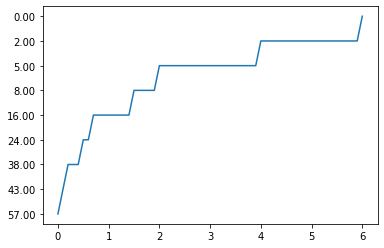

In [34]:
import matplotlib.pyplot as plt                               #支持中文
#mpl.rcParams['font.sans-serif'] = ['SimHei']
alpha = []
i = 0
while i <= 6:
    alpha.append(i)
    i += 0.1
#names = ['5', '10', '15', '20', '25']
#x = range(len(names))
y = pianyi
x = alpha
plt.plot(x, y)
plt.show()

In [10]:
import matplotlib.pyplot as plt 

In [2]:
def sketch_map(W, w, h, x, y, p, name):
    """
    画结果示意图
    W: 容器的宽度
    w: 数组，为每个箱子的宽度
    h: 数组，为每个箱子的高度
    p: 数组，为每个箱子的偏好位置
    x: 数组，为每个箱子左下角x坐标
    y: 数组，为每个箱子左下角y坐标
    name: str，图片保存名字
    """
    # 先确定x,y轴范围
    y_label_range = 1.6 * max([i + j for i, j in zip(y, h)])
    x_label_range = W
    
    # 开始做图
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    #建立矩形
    for i in range(len(w)):
        rect = plt.Rectangle(
                (x[i], y[i]),  # (x,y)矩形左下角
                w[i],          # width长
                h[i],          # height宽
                color='maroon', 
                alpha=0.5)
        ax.add_patch(rect)
        ax.text(x[i], y[i],
                str(x[i]) + ';' + str(y[i]) + ';' + str(w[i]) + ';' + str(h[i]),
                bbox=dict(facecolor='blue', alpha=0),
                fontsize=14, color='black')
    # 建立图
    plt.xlim(0, x_label_range)
    plt.ylim(0, y_label_range)
    plt.show()
    plt.savefig(name + ".png")

In [52]:
tmp = res[0]

In [54]:
tmp

{'d[1,2]': -0.0,
 'd[1,3]': -0.0,
 'd[1,4]': -0.0,
 'd[1,5]': 0.0,
 'd[1,6]': -0.0,
 'd[1,7]': -0.0,
 'd[1,8]': -0.0,
 'd[1,9]': -0.0,
 'd[2,1]': -0.0,
 'd[2,3]': -0.0,
 'd[2,4]': -0.0,
 'd[2,5]': -0.0,
 'd[2,6]': -0.0,
 'd[2,7]': -0.0,
 'd[2,8]': -0.0,
 'd[2,9]': -0.0,
 'd[3,1]': 1.0,
 'd[3,2]': 1.0,
 'd[3,4]': -0.0,
 'd[3,5]': 1.0,
 'd[3,6]': 1.0,
 'd[3,7]': -0.0,
 'd[3,8]': -0.0,
 'd[3,9]': -0.0,
 'd[4,1]': -0.0,
 'd[4,2]': 1.0,
 'd[4,3]': -0.0,
 'd[4,5]': -0.0,
 'd[4,6]': 1.0,
 'd[4,7]': -0.0,
 'd[4,8]': -0.0,
 'd[4,9]': -0.0,
 'd[5,1]': -0.0,
 'd[5,2]': -0.0,
 'd[5,3]': 0.0,
 'd[5,4]': -0.0,
 'd[5,6]': -0.0,
 'd[5,7]': -0.0,
 'd[5,8]': -0.0,
 'd[5,9]': -0.0,
 'd[6,1]': -0.0,
 'd[6,2]': -0.0,
 'd[6,3]': 0.0,
 'd[6,4]': -0.0,
 'd[6,5]': -0.0,
 'd[6,7]': -0.0,
 'd[6,8]': -0.0,
 'd[6,9]': 9.99999999995449e-06,
 'd[7,1]': -0.0,
 'd[7,2]': -0.0,
 'd[7,3]': -0.0,
 'd[7,4]': -0.0,
 'd[7,5]': 1.0,
 'd[7,6]': -0.0,
 'd[7,8]': -0.0,
 'd[7,9]': -0.0,
 'd[8,1]': -0.0,
 'd[8,2]': -0.0,
 'd[8,3]

In [51]:
tmp = jijiji
x = []
y = []
for i in tmp:
    if i[0] == 'x':
        tmpp = float('%.1f' % tmp[i])
        x.append(tmpp)
    elif i[0] == 'y' and i[1] == '[':
        tmpp = float('%.1f' % tmp[i])
        y.append(tmpp)

In [52]:
x

[11.0, 8.0, 7.0, 8.0, 8.0, 10.0, 15.0, -0.0, -0.0, 11.0]

In [53]:
y

[-0.0, -0.0, 5.0, 13.0, 19.0, 5.0, -0.0, -0.0, 14.0, 12.0]

In [54]:
w = {}     # 箱子宽
h = {}     # 箱子高
p = {}     # 箱子偏好位置
w[1], h[1] = 2, 5
w[2], h[2] = 3, 5
w[3], h[3] = 3, 6
w[4], h[4] = 3, 6
w[5], h[5] = 3, 7
w[6], h[6] = 5, 7
w[7], h[7] = 5, 12
w[8], h[8] = 7, 12
w[9], h[9] = 8, 12
w[10], h[10] = 9, 14

In [55]:
ww = []
hh = []
for i in w:
    ww.append(w[i])
    hh.append(h[i])

In [29]:
len(x)

10

In [31]:
p = [1 for i in range(11)]

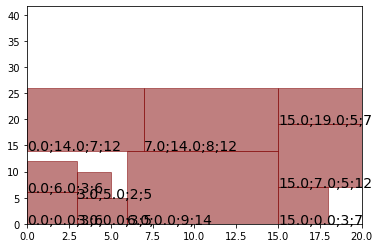

<Figure size 432x288 with 0 Axes>

In [44]:
sketch_map(20, ww, hh, x, y, p, 'test')

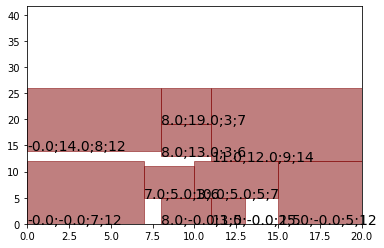

<Figure size 432x288 with 0 Axes>

In [56]:
sketch_map(20, ww, hh, x, y, p, 'test')

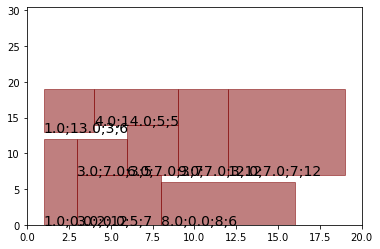

<Figure size 432x288 with 0 Axes>

In [101]:
sketch_map(20, ww, hh, x, y, p, 'test')

In [71]:
y

['6.0',
 '6.0',
 '0.0',
 '0.0',
 '13.0',
 '13.0',
 '1.0',
 '0.0',
 '7.0',
 '18.0',
 '18.0',
 '6.0',
 '6.0',
 '18.0',
 '18.0',
 '13.0',
 '7.0',
 '14.0']

In [89]:
t = res[0]

In [90]:
t

{'d[1,2]': -0.0,
 'd[1,3]': -0.0,
 'd[1,4]': -0.0,
 'd[1,5]': 0.0,
 'd[1,6]': -0.0,
 'd[1,7]': -0.0,
 'd[1,8]': -0.0,
 'd[1,9]': -0.0,
 'd[2,1]': -0.0,
 'd[2,3]': -0.0,
 'd[2,4]': -0.0,
 'd[2,5]': -0.0,
 'd[2,6]': -0.0,
 'd[2,7]': -0.0,
 'd[2,8]': -0.0,
 'd[2,9]': -0.0,
 'd[3,1]': 1.0,
 'd[3,2]': 1.0,
 'd[3,4]': -0.0,
 'd[3,5]': 1.0,
 'd[3,6]': 1.0,
 'd[3,7]': -0.0,
 'd[3,8]': -0.0,
 'd[3,9]': -0.0,
 'd[4,1]': -0.0,
 'd[4,2]': 1.0,
 'd[4,3]': -0.0,
 'd[4,5]': -0.0,
 'd[4,6]': 1.0,
 'd[4,7]': -0.0,
 'd[4,8]': -0.0,
 'd[4,9]': -0.0,
 'd[5,1]': -0.0,
 'd[5,2]': -0.0,
 'd[5,3]': 0.0,
 'd[5,4]': -0.0,
 'd[5,6]': -0.0,
 'd[5,7]': -0.0,
 'd[5,8]': -0.0,
 'd[5,9]': -0.0,
 'd[6,1]': -0.0,
 'd[6,2]': -0.0,
 'd[6,3]': 0.0,
 'd[6,4]': -0.0,
 'd[6,5]': -0.0,
 'd[6,7]': -0.0,
 'd[6,8]': -0.0,
 'd[6,9]': 9.99999999995449e-06,
 'd[7,1]': -0.0,
 'd[7,2]': -0.0,
 'd[7,3]': -0.0,
 'd[7,4]': -0.0,
 'd[7,5]': 1.0,
 'd[7,6]': -0.0,
 'd[7,8]': -0.0,
 'd[7,9]': -0.0,
 'd[8,1]': -0.0,
 'd[8,2]': -0.0,
 'd[8,3]

In [112]:
import random
w = {}     # 箱子宽
h = {}     # 箱子高
p = {}     # 箱子偏好位置
w[1], h[1] = 2, 12
w[2], h[2] = 7, 12
w[3], h[3] = 8, 6
w[4], h[4] = 3, 6
w[5], h[5] = 3, 5
w[6], h[6] = 5, 5
w[7], h[7] = 3, 12
w[8], h[8] = 3, 7
w[9], h[9] = 5, 7
'''
w[10], h[10] = 2, 6
w[11], h[11] = 3, 2
w[12], h[12] = 4, 2
w[13], h[13] = 3, 4
w[14], h[14] = 4, 4
w[15], h[15] = 9, 2 
w[16], h[16] = 11, 2
'''
for i in range(1, 10):
    p[i] = 1
variables = {}
variables['N'] = 9
variables['W'] = 20
variables['w'] = w
variables['h'] = h
variables['p'] = p
i = 0
#while i <= 6:     
variables['alpha'] = i
result1 = gb_solver(variables)
# res.append(result['pcount'])
#i += 0.1

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 190 columns and 783 nonzeros
Model fingerprint: 0x49ee1a87
Model has 10 general constraints
Variable types: 46 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 27 columns
Presolve time: 0.00s
Presolved: 261 rows, 163 columns, 738 nonzeros
Variable types: 19 continuous, 144 integer (144 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 1.200000e+01, 62 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0   10   72.00000   12.00000  83.3%     -

/var/folders/ql/z86w4c4j6gd0wbzf4c8mk1dr0000gn/T/ipykernel_15037/3598597666.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  m.setObjective(h_max + alpha * sum(pxf[i] for i in item_list), GRB.MINIMIZE)


In [110]:
result1


{'d[1,2]': -0.0,
 'd[1,3]': -0.0,
 'd[1,4]': -0.0,
 'd[1,5]': -0.0,
 'd[1,6]': -0.0,
 'd[1,7]': -0.0,
 'd[1,8]': -0.0,
 'd[1,9]': -0.0,
 'd[2,1]': -0.0,
 'd[2,3]': -0.0,
 'd[2,4]': -0.0,
 'd[2,5]': -0.0,
 'd[2,6]': -0.0,
 'd[2,7]': -0.0,
 'd[2,8]': -0.0,
 'd[2,9]': -0.0,
 'd[3,1]': -0.0,
 'd[3,2]': 0.9999999994,
 'd[3,4]': -0.0,
 'd[3,5]': -0.0,
 'd[3,6]': -0.0,
 'd[3,7]': -0.0,
 'd[3,8]': -0.0,
 'd[3,9]': 0.9999999994,
 'd[4,1]': 0.9999999994,
 'd[4,2]': -0.0,
 'd[4,3]': -0.0,
 'd[4,5]': -0.0,
 'd[4,6]': -0.0,
 'd[4,7]': -0.0,
 'd[4,8]': -0.0,
 'd[4,9]': -0.0,
 'd[5,1]': 0.9999999995,
 'd[5,2]': -0.0,
 'd[5,3]': -0.0,
 'd[5,4]': 0.9999999995,
 'd[5,6]': -0.0,
 'd[5,7]': -0.0,
 'd[5,8]': -0.0,
 'd[5,9]': -0.0,
 'd[6,1]': -0.0,
 'd[6,2]': 0.9999999995,
 'd[6,3]': -0.0,
 'd[6,4]': -0.0,
 'd[6,5]': -0.0,
 'd[6,7]': -0.0,
 'd[6,8]': -0.0,
 'd[6,9]': -0.0,
 'd[7,1]': -0.0,
 'd[7,2]': -0.0,
 'd[7,3]': -0.0,
 'd[7,4]': -0.0,
 'd[7,5]': -0.0,
 'd[7,6]': -0.0,
 'd[7,8]': -0.0,
 'd[7,9]': -0.0,


In [113]:
tttt = {'d[1,2]': -0.0, 'd[1,3]': -0.0, 'd[1,4]': -0.0, 'd[1,5]': -0.0, 'd[1,6]': -0.0, 'd[1,7]': -0.0, 'd[1,8]': -0.0, 'd[1,9]': -0.0, 'd[2,1]': -0.0, 'd[2,3]': 1.0, 'd[2,4]': -0.0, 'd[2,5]': 1.0, 'd[2,6]': -0.0, 'd[2,7]': -0.0, 'd[2,8]': -0.0, 'd[2,9]': -0.0, 'd[3,1]': -0.0, 'd[3,2]': -0.0, 'd[3,4]': -0.0, 'd[3,5]': -0.0, 'd[3,6]': -0.0, 'd[3,7]': -0.0, 'd[3,8]': -0.0, 'd[3,9]': 0.0, 'd[4,1]': -0.0, 'd[4,2]': -0.0, 'd[4,3]': -0.0, 'd[4,5]': 1.0, 'd[4,6]': -0.0, 'd[4,7]': -0.0, 'd[4,8]': -0.0, 'd[4,9]': -0.0, 'd[5,1]': -0.0, 'd[5,2]': -0.0, 'd[5,3]': -0.0, 'd[5,4]': 0.0, 'd[5,6]': -0.0, 'd[5,7]': -0.0, 'd[5,8]': -0.0, 'd[5,9]': -0.0, 'd[6,1]': 1.0, 'd[6,2]': -0.0, 'd[6,3]': 1.0, 'd[6,4]': -0.0, 'd[6,5]': -0.0, 'd[6,7]': 1.0, 'd[6,8]': -0.0, 'd[6,9]': -0.0, 'd[7,1]': -0.0, 'd[7,2]': -0.0, 'd[7,3]': -0.0, 'd[7,4]': -0.0, 'd[7,5]': -0.0, 'd[7,6]': -0.0, 'd[7,8]': -0.0, 'd[7,9]': -0.0, 'd[8,1]': -0.0, 'd[8,2]': -0.0, 'd[8,3]': -0.0, 'd[8,4]': -0.0, 'd[8,5]': -0.0, 'd[8,6]': -0.0, 'd[8,7]': -0.0, 'd[8,9]': -0.0, 'd[9,1]': -0.0, 'd[9,2]': -0.0, 'd[9,3]': 1.0, 'd[9,4]': 1.0, 'd[9,5]': 1.0, 'd[9,6]': -0.0, 'd[9,7]': -0.0, 'd[9,8]': 1.0, 'l[1,2]': 1.0, 'l[1,3]': 1.0000000000000002, 'l[1,4]': 1.0, 'l[1,5]': 1.0, 'l[1,6]': -0.0, 'l[1,7]': -0.0, 'l[1,8]': 1.0, 'l[1,9]': 1.0, 'l[2,1]': 0.0, 'l[2,3]': -0.0, 'l[2,4]': 1.0, 'l[2,5]': 0.0, 'l[2,6]': 0.0, 'l[2,7]': -0.0, 'l[2,8]': 1.0, 'l[2,9]': 1.0, 'l[3,1]': -0.0, 'l[3,2]': 0.0, 'l[3,4]': 1.0, 'l[3,5]': 1.0, 'l[3,6]': 0.0, 'l[3,7]': -0.0, 'l[3,8]': 1.0, 'l[3,9]': -0.0, 'l[4,1]': 0.0, 'l[4,2]': -0.0, 'l[4,3]': -0.0, 'l[4,5]': 0.0, 'l[4,6]': -0.0, 'l[4,7]': -0.0, 'l[4,8]': 1.1102230246251565e-16, 'l[4,9]': -0.0, 'l[5,1]': -0.0, 'l[5,2]': -0.0, 'l[5,3]': 0.0, 'l[5,4]': -0.0, 'l[5,6]': -0.0, 'l[5,7]': -0.0, 'l[5,8]': -0.0, 'l[5,9]': 0.0, 'l[6,1]': 0.0, 'l[6,2]': 1.0, 'l[6,3]': -0.0, 'l[6,4]': 1.0, 'l[6,5]': 1.0, 'l[6,7]': -0.0, 'l[6,8]': 1.0, 'l[6,9]': 1.0, 'l[7,1]': 1.0, 'l[7,2]': 1.0, 'l[7,3]': 1.0, 'l[7,4]': 1.0, 'l[7,5]': 1.0, 'l[7,6]': 0.0, 'l[7,8]': 1.0, 'l[7,9]': 1.0, 'l[8,1]': -0.0, 'l[8,2]': -0.0, 'l[8,3]': 0.0, 'l[8,4]': 0.9999999999999998, 'l[8,5]': 1.0, 'l[8,6]': 0.0, 'l[8,7]': 0.0, 'l[8,9]': -0.0, 'l[9,1]': -0.0, 'l[9,2]': 0.0, 'l[9,3]': 0.0, 'l[9,4]': -0.0, 'l[9,5]': -0.0, 'l[9,6]': -0.0, 'l[9,7]': -0.0, 'l[9,8]': 0.0, 'x[1]': 4.0, 'x[2]': 6.0, 'x[3]': 6.0000000000000036, 'x[4]': 17.0, 'x[5]': 17.0, 'x[6]': 1.0, 'x[7]': 1.0, 'x[8]': 14.000000000000004, 'x[9]': 15.0, 'y[1]': 5.000000000000003, 'y[2]': 0.0, 'y[3]': 11.999999999999943, 'y[4]': 6.99999999999997, 'y[5]': 12.999999999999943, 'y[6]': 0.0, 'y[7]': 4.999999999999973, 'y[8]': 6.999999999999976, 'y[9]': 0.0, 'h_max': 17.999999999999943, 'px[1]': 3.0, 'px[2]': 5.0, 'px[3]': 5.0000000000000036, 'px[4]': 16.0, 'px[5]': 16.0, 'px[6]': 0.0, 'px[7]': 0.0, 'px[8]': 13.000000000000004, 'px[9]': 14.0, 'yh[1]': 17.000000000000004, 'yh[2]': 12.0, 'yh[3]': 17.999999999999943, 'yh[4]': 12.99999999999997, 'yh[5]': 17.999999999999943, 'yh[6]': 5.0, 'yh[7]': 16.99999999999997, 'yh[8]': 13.999999999999975, 'yh[9]': 7.0, 'pxf[1]': 3.0, 'pxf[2]': 5.0, 'pxf[3]': 5.0000000000000036, 'pxf[4]': 16.0, 'pxf[5]': 16.0, 'pxf[6]': 0.0, 'pxf[7]': 0.0, 'pxf[8]': 13.000000000000004, 'pxf[9]': 14.0, 'Obj': 17.999999999999943, 'Runtime': 0.12202906608581543, 'pcount': 72.0}

In [119]:
ttt = {'d[1,2]': -0.0, 'd[1,3]': -0.0, 'd[1,4]': -0.0, 'd[1,5]': -0.0, 'd[1,6]': 1.0, 'd[1,7]': -0.0, 'd[1,8]': -0.0, 'd[1,9]': -0.0, 'd[2,1]': -0.0, 'd[2,3]': 1.0, 'd[2,4]': 1.0, 'd[2,5]': -0.0, 'd[2,6]': -0.0, 'd[2,7]': -0.0, 'd[2,8]': -0.0, 'd[2,9]': -0.0, 'd[3,1]': -0.0, 'd[3,2]': -0.0, 'd[3,4]': -0.0, 'd[3,5]': -0.0, 'd[3,6]': -0.0, 'd[3,7]': -0.0, 'd[3,8]': -0.0, 'd[3,9]': -0.0, 'd[4,1]': -0.0, 'd[4,2]': -0.0, 'd[4,3]': -0.0, 'd[4,5]': 0.0, 'd[4,6]': -0.0, 'd[4,7]': -0.0, 'd[4,8]': -0.0, 'd[4,9]': -0.0, 'd[5,1]': -0.0, 'd[5,2]': -0.0, 'd[5,3]': 1.0, 'd[5,4]': 1.0, 'd[5,6]': 1.0, 'd[5,7]': -0.0, 'd[5,8]': -0.0, 'd[5,9]': -0.0, 'd[6,1]': -0.0, 'd[6,2]': -0.0, 'd[6,3]': -0.0, 'd[6,4]': -0.0, 'd[6,5]': -0.0, 'd[6,7]': -0.0, 'd[6,8]': -0.0, 'd[6,9]': -0.0, 'd[7,1]': -0.0, 'd[7,2]': -0.0, 'd[7,3]': -0.0, 'd[7,4]': -0.0, 'd[7,5]': -0.0, 'd[7,6]': 1.0, 'd[7,8]': -0.0, 'd[7,9]': -0.0, 'd[8,1]': -0.0, 'd[8,2]': -0.0, 'd[8,3]': -0.0, 'd[8,4]': -0.0, 'd[8,5]': -0.0, 'd[8,6]': -0.0, 'd[8,7]': -0.0, 'd[8,9]': -0.0, 'd[9,1]': -0.0, 'd[9,2]': -0.0, 'd[9,3]': 1.0, 'd[9,4]': 1.0, 'd[9,5]': 1.0, 'd[9,6]': 1.0, 'd[9,7]': -0.0, 'd[9,8]': 1.0, 'l[1,2]': 0.0, 'l[1,3]': -0.0, 'l[1,4]': -0.0, 'l[1,5]': -0.0, 'l[1,6]': -0.0, 'l[1,7]': 1.0, 'l[1,8]': -0.0, 'l[1,9]': 0.0, 'l[2,1]': 1.0, 'l[2,3]': -0.0, 'l[2,4]': -0.0, 'l[2,5]': 1.0, 'l[2,6]': 1.0, 'l[2,7]': 1.0, 'l[2,8]': 1.0, 'l[2,9]': 1.0, 'l[3,1]': 1.0, 'l[3,2]': -0.0, 'l[3,4]': 1.0, 'l[3,5]': 0.0, 'l[3,6]': 1.0, 'l[3,7]': 1.0, 'l[3,8]': 1.0, 'l[3,9]': -0.0, 'l[4,1]': 1.0, 'l[4,2]': -0.0, 'l[4,3]': -0.0, 'l[4,5]': 0.0, 'l[4,6]': 1.0, 'l[4,7]': 1.0, 'l[4,8]': -0.0, 'l[4,9]': 0.0, 'l[5,1]': 1.0, 'l[5,2]': -0.0, 'l[5,3]': -0.0, 'l[5,4]': -0.0, 'l[5,6]': 2.220446049250313e-16, 'l[5,7]': 1.0, 'l[5,8]': -0.0, 'l[5,9]': -0.0, 'l[6,1]': 0.0, 'l[6,2]': -0.0, 'l[6,3]': -0.0, 'l[6,4]': -0.0, 'l[6,5]': -0.0, 'l[6,7]': 0.0, 'l[6,8]': -0.0, 'l[6,9]': 0.0, 'l[7,1]': -0.0, 'l[7,2]': -0.0, 'l[7,3]': 0.0, 'l[7,4]': -0.0, 'l[7,5]': -0.0, 'l[7,6]': -0.0, 'l[7,8]': -0.0, 'l[7,9]': 0.0, 'l[8,1]': 1.0, 'l[8,2]': -0.0, 'l[8,3]': 0.0, 'l[8,4]': 1.0, 'l[8,5]': 1.0, 'l[8,6]': 1.0, 'l[8,7]': 1.0, 'l[8,9]': -0.0, 'l[9,1]': 1.0, 'l[9,2]': 0.0, 'l[9,3]': 0.0, 'l[9,4]': -0.0, 'l[9,5]': -0.0, 'l[9,6]': -0.0, 'l[9,7]': 1.0, 'l[9,8]': 0.0, 'x[1]': 15.0, 'x[2]': 1.0, 'x[3]': 1.0, 'x[4]': 12.0, 'x[5]': 12.0, 'x[6]': 15.0, 'x[7]': 17.0, 'x[8]': 9.0, 'x[9]': 8.0, 'y[1]': -4.574118861455645e-14, 'y[2]': 0.0, 'y[3]': 11.999999999999801, 'y[4]': 11.999999999999801, 'y[5]': 6.999999999999954, 'y[6]': 11.999999999999954, 'y[7]': 0.0, 'y[8]': 10.999999999999801, 'y[9]': -4.618527782440651e-14, 'h_max': 17.9999999999998, 'px[1]': 14.0, 'px[2]': 0.0, 'px[3]': 0.0, 'px[4]': 11.0, 'px[5]': 11.0, 'px[6]': 14.0, 'px[7]': 16.0, 'px[8]': 8.0, 'px[9]': 7.0, 'yh[1]': 11.999999999999954, 'yh[2]': 12.0, 'yh[3]': 17.9999999999998, 'yh[4]': 17.9999999999998, 'yh[5]': 11.999999999999954, 'yh[6]': 16.999999999999954, 'yh[7]': 12.0, 'yh[8]': 17.9999999999998, 'yh[9]': 6.999999999999954, 'pxf[1]': 14.0, 'pxf[2]': 0.0, 'pxf[3]': 0.0, 'pxf[4]': 11.0, 'pxf[5]': 11.0, 'pxf[6]': 14.0, 'pxf[7]': 16.0, 'pxf[8]': 8.0, 'pxf[9]': 7.0, 'Obj': 17.9999999999998, 'Runtime': 0.20054221153259277, 'pcount': 81.0}

In [45]:
jj = {'d[1,2]': 0.0, 'd[1,3]': 0.0, 'd[1,4]': 0.0, 'd[1,5]': 0.0, 'd[1,6]': 0.0, 'd[1,7]': 0.0, 'd[1,8]': 0.0, 'd[1,9]': 0.0, 'd[2,1]': 1.0, 'd[2,3]': 0.0, 'd[2,4]': 0.0, 'd[2,5]': 0.0, 'd[2,6]': 0.0, 'd[2,7]': 0.0, 'd[2,8]': 0.0, 'd[2,9]': 0.0, 'd[3,1]': 0.0, 'd[3,2]': 0.0, 'd[3,4]': 1.0, 'd[3,5]': 0.0, 'd[3,6]': 0.0, 'd[3,7]': 0.0, 'd[3,8]': 0.0, 'd[3,9]': 0.0, 'd[4,1]': 0.0, 'd[4,2]': 0.0, 'd[4,3]': 0.0, 'd[4,5]': 0.0, 'd[4,6]': 0.0, 'd[4,7]': 0.0, 'd[4,8]': 0.0, 'd[4,9]': 0.0, 'd[5,1]': 1.0, 'd[5,2]': 1.0, 'd[5,3]': 0.0, 'd[5,4]': 0.0, 'd[5,6]': 0.0, 'd[5,7]': 0.0, 'd[5,8]': 0.0, 'd[5,9]': 0.0, 'd[6,1]': 0.0, 'd[6,2]': 0.0, 'd[6,3]': 0.0, 'd[6,4]': 0.0, 'd[6,5]': 0.0, 'd[6,7]': 1.0, 'd[6,8]': 0.0, 'd[6,9]': 0.0, 'd[7,1]': 0.0, 'd[7,2]': 0.0, 'd[7,3]': 0.0, 'd[7,4]': 0.0, 'd[7,5]': 0.0, 'd[7,6]': 0.0, 'd[7,8]': 0.0, 'd[7,9]': 0.0, 'd[8,1]': 0.0, 'd[8,2]': 0.0, 'd[8,3]': 0.0, 'd[8,4]': 0.0, 'd[8,5]': 0.0, 'd[8,6]': 0.0, 'd[8,7]': 0.0, 'd[8,9]': 1.0, 'd[9,1]': 0.0, 'd[9,2]': 0.0, 'd[9,3]': 0.0, 'd[9,4]': 0.0, 'd[9,5]': 0.0, 'd[9,6]': 0.0, 'd[9,7]': 0.0, 'd[9,8]': 0.0, 'l[1,2]': 0.0, 'l[1,3]': 1.0, 'l[1,4]': 1.0, 'l[1,5]': 0.0, 'l[1,6]': 1.0, 'l[1,7]': 1.0, 'l[1,8]': 1.0, 'l[1,9]': 1.0, 'l[2,1]': 0.0, 'l[2,3]': 1.0, 'l[2,4]': 1.0, 'l[2,5]': 0.0, 'l[2,6]': 1.0, 'l[2,7]': 1.0, 'l[2,8]': 1.0, 'l[2,9]': 1.0, 'l[3,1]': 0.0, 'l[3,2]': 0.0, 'l[3,4]': 0.0, 'l[3,5]': 0.0, 'l[3,6]': 0.0, 'l[3,7]': 0.0, 'l[3,8]': 0.0, 'l[3,9]': 0.0, 'l[4,1]': 0.0, 'l[4,2]': 0.0, 'l[4,3]': 0.0, 'l[4,5]': 0.0, 'l[4,6]': 0.0, 'l[4,7]': 0.0, 'l[4,8]': 0.0, 'l[4,9]': 0.0, 'l[5,1]': 0.0, 'l[5,2]': 0.0, 'l[5,3]': 1.0, 'l[5,4]': 1.0, 'l[5,6]': 1.0, 'l[5,7]': 1.0, 'l[5,8]': 1.0, 'l[5,9]': 1.0, 'l[6,1]': 0.0, 'l[6,2]': 0.0, 'l[6,3]': 1.0, 'l[6,4]': 1.0, 'l[6,5]': 0.0, 'l[6,7]': 0.0, 'l[6,8]': 0.0, 'l[6,9]': 0.0, 'l[7,1]': 0.0, 'l[7,2]': 0.0, 'l[7,3]': 1.0, 'l[7,4]': 1.0, 'l[7,5]': 0.0, 'l[7,6]': 0.0, 'l[7,8]': 0.0, 'l[7,9]': 0.0, 'l[8,1]': 0.0, 'l[8,2]': 0.0, 'l[8,3]': 1.0, 'l[8,4]': 1.0, 'l[8,5]': 0.0, 'l[8,6]': 1.0, 'l[8,7]': 1.0, 'l[8,9]': 0.0, 'l[9,1]': 0.0, 'l[9,2]': 0.0, 'l[9,3]': 1.0, 'l[9,4]': 1.0, 'l[9,5]': 0.0, 'l[9,6]': 1.0, 'l[9,7]': 1.0, 'l[9,8]': 0.0, 'x[1]': 1.0, 'x[2]': 1.0, 'x[3]': 17.0, 'x[4]': 17.0, 'x[5]': 1.0, 'x[6]': 12.0, 'x[7]': 12.0, 'x[8]': 4.0, 'x[9]': 4.0, 'y[1]': 12.0, 'y[2]': 7.0, 'y[3]': 0.0, 'y[4]': 6.0, 'y[5]': 0.0, 'y[6]': 0.0, 'y[7]': 7.0, 'y[8]': 0.0, 'y[9]': 12.0, 'h_max': 24.0, 'px[1]': 0.0, 'px[2]': 0.0, 'px[3]': 16.0, 'px[4]': 16.0, 'px[5]': 0.0, 'px[6]': 11.0, 'px[7]': 11.0, 'px[8]': 3.0, 'px[9]': 3.0, 'yh[1]': 17.0, 'yh[2]': 12.0, 'yh[3]': 6.0, 'yh[4]': 12.0, 'yh[5]': 7.0, 'yh[6]': 7.0, 'yh[7]': 19.0, 'yh[8]': 12.0, 'yh[9]': 24.0, 'pxf[1]': 0.0, 'pxf[2]': 0.0, 'pxf[3]': 16.0, 'pxf[4]': 16.0, 'pxf[5]': 0.0, 'pxf[6]': 11.0, 'pxf[7]': 11.0, 'pxf[8]': 3.0, 'pxf[9]': 3.0, 'Obj': 24.0, 'Runtime': 0.02050185203552246, 'pcount': 60.0}

In [1]:
jjj = {'d[1,2]': 1.0, 'd[1,3]': 1.0, 'd[1,4]': 0.0, 'd[1,5]': 1.0, 'd[1,6]': -0.0, 'd[1,7]': 1.0, 'd[1,8]': -0.0, 'd[1,9]': 1.0, 'd[1,10]': -0.0, 'd[2,1]': 0.0, 'd[2,3]': 1.0, 'd[2,4]': -0.0, 'd[2,5]': 1.0, 'd[2,6]': -0.0, 'd[2,7]': -0.0, 'd[2,8]': -0.0, 'd[2,9]': 1.0, 'd[2,10]': -0.0, 'd[3,1]': -0.0, 'd[3,2]': -0.0, 'd[3,4]': -0.0, 'd[3,5]': -0.0, 'd[3,6]': -0.0, 'd[3,7]': 0.0, 'd[3,8]': -0.0, 'd[3,9]': -0.0, 'd[3,10]': -0.0, 'd[4,1]': 1.0, 'd[4,2]': 1.0, 'd[4,3]': 1.0, 'd[4,5]': 0.0, 'd[4,6]': 1.0, 'd[4,7]': -0.0, 'd[4,8]': -0.0, 'd[4,9]': 1.0, 'd[4,10]': -0.0, 'd[5,1]': -0.0, 'd[5,2]': -0.0, 'd[5,3]': -0.0, 'd[5,4]': -0.0, 'd[5,6]': -0.0, 'd[5,7]': -0.0, 'd[5,8]': 0.0, 'd[5,9]': -0.0, 'd[5,10]': -0.0, 'd[6,1]': 0.0, 'd[6,2]': -0.0, 'd[6,3]': 1.0, 'd[6,4]': -0.0, 'd[6,5]': 1.0, 'd[6,7]': -0.0, 'd[6,8]': -0.0, 'd[6,9]': -0.0, 'd[6,10]': -0.0, 'd[7,1]': -0.0, 'd[7,2]': -0.0, 'd[7,3]': -0.0, 'd[7,4]': 0.0, 'd[7,5]': 0.0, 'd[7,6]': 0.0, 'd[7,8]': -0.0, 'd[7,9]': -0.0, 'd[7,10]': -0.0, 'd[8,1]': -0.0, 'd[8,2]': -0.0, 'd[8,3]': 1.0, 'd[8,4]': 0.0, 'd[8,5]': 1.0, 'd[8,6]': 1.0, 'd[8,7]': -0.0, 'd[8,9]': 1.0, 'd[8,10]': -0.0, 'd[9,1]': -0.0, 'd[9,2]': -0.0, 'd[9,3]': -0.0, 'd[9,4]': -0.0, 'd[9,5]': -0.0, 'd[9,6]': -0.0, 'd[9,7]': 0.0, 'd[9,8]': -0.0, 'd[9,10]': -0.0, 'd[10,1]': -0.0, 'd[10,2]': 0.0, 'd[10,3]': -0.0, 'd[10,4]': -0.0, 'd[10,5]': 1.0, 'd[10,6]': -0.0, 'd[10,7]': 1.0, 'd[10,8]': -0.0, 'd[10,9]': 1.0, 'l[1,2]': -0.0, 'l[1,3]': -0.0, 'l[1,4]': -0.0, 'l[1,5]': -0.0, 'l[1,6]': -0.0, 'l[1,7]': -0.0, 'l[1,8]': -0.0, 'l[1,9]': -0.0, 'l[1,10]': 1.0, 'l[2,1]': 0.0, 'l[2,3]': -0.0, 'l[2,4]': -0.0, 'l[2,5]': -0.0, 'l[2,6]': -0.0, 'l[2,7]': 1.0, 'l[2,8]': -0.0, 'l[2,9]': -0.0, 'l[2,10]': 1.0, 'l[3,1]': -0.0, 'l[3,2]': -0.0, 'l[3,4]': -0.0, 'l[3,5]': 0.0, 'l[3,6]': -0.0, 'l[3,7]': 1.0, 'l[3,8]': -0.0, 'l[3,9]': 1.0, 'l[3,10]': 1.0, 'l[4,1]': -0.0, 'l[4,2]': -0.0, 'l[4,3]': -0.0, 'l[4,5]': -0.0, 'l[4,6]': -0.0, 'l[4,7]': 1.0, 'l[4,8]': -0.0, 'l[4,9]': -0.0, 'l[4,10]': 1.0, 'l[5,1]': -0.0, 'l[5,2]': -0.0, 'l[5,3]': 1.0, 'l[5,4]': 1.0, 'l[5,6]': 0.0, 'l[5,7]': 1.0, 'l[5,8]': -0.0, 'l[5,9]': 1.0, 'l[5,10]': -0.0, 'l[6,1]': 1.0, 'l[6,2]': 1.0, 'l[6,3]': -0.0, 'l[6,4]': -0.0, 'l[6,5]': -0.0, 'l[6,7]': 1.0, 'l[6,8]': -0.0, 'l[6,9]': 1.0, 'l[6,10]': 1.0, 'l[7,1]': -0.0, 'l[7,2]': -0.0, 'l[7,3]': -0.0, 'l[7,4]': 0.0, 'l[7,5]': -0.0, 'l[7,6]': -0.0, 'l[7,8]': 0.0, 'l[7,9]': -0.0, 'l[7,10]': 0.0, 'l[8,1]': 1.0, 'l[8,2]': 1.0, 'l[8,3]': -0.0, 'l[8,4]': 1.0, 'l[8,5]': -0.0, 'l[8,6]': -0.0, 'l[8,7]': 1.0, 'l[8,9]': 0.0, 'l[8,10]': 1.0, 'l[9,1]': -0.0, 'l[9,2]': -0.0, 'l[9,3]': -0.0, 'l[9,4]': -0.0, 'l[9,5]': -0.0, 'l[9,6]': -0.0, 'l[9,7]': 1.0, 'l[9,8]': -0.0, 'l[9,10]': -0.0, 'l[10,1]': 0.0, 'l[10,2]': -0.0, 'l[10,3]': -0.0, 'l[10,4]': 0.0, 'l[10,5]': -0.0, 'l[10,6]': -0.0, 'l[10,7]': -0.0, 'l[10,8]': -0.0, 'l[10,9]': -0.0, 'x[1]': 8.0, 'x[2]': 8.0, 'x[3]': 4.0, 'x[4]': 8.0, 'x[5]': 1.0, 'x[6]': 1.0, 'x[7]': 15.0, 'x[8]': 1.0, 'x[9]': 7.0, 'x[10]': 11.0, 'y[1]': 6.0, 'y[2]': 11.0, 'y[3]': 18.999999999999996, 'y[4]': 0.0, 'y[5]': 20.999999997091177, 'y[6]': 11.999999999999996, 'y[7]': 15.999999997091177, 'y[8]': 0.0, 'y[9]': 15.999999997091177, 'y[10]': 0.0, 'h_max': 27.999999997091173, 'px[1]': 7.0, 'px[2]': 7.0, 'px[3]': 3.0, 'px[4]': 7.0, 'px[5]': 0.0, 'px[6]': 0.0, 'px[7]': 14.0, 'px[8]': 0.0, 'px[9]': 6.0, 'px[10]': 10.0, 'yh[1]': 11.0, 'yh[2]': 16.0, 'yh[3]': 24.999999999999996, 'yh[4]': 6.0, 'yh[5]': 27.999999997091177, 'yh[6]': 18.999999999999996, 'yh[7]': 27.999999997091177, 'yh[8]': 12.0, 'yh[9]': 27.999999997091177, 'yh[10]': 14.0, 'pxf[1]': 7.0, 'pxf[2]': 7.0, 'pxf[3]': 3.0, 'pxf[4]': 7.0, 'pxf[5]': 0.0, 'pxf[6]': 0.0, 'pxf[7]': 14.0, 'pxf[8]': 0.0, 'pxf[9]': 6.0, 'pxf[10]': 10.0, 'Obj': 27.999999997091173, 'Runtime': 5.447037220001221, 'pcount': 54.0}

In [19]:
jiji = {'d[1,2]': 0.0, 'd[1,3]': 1.0, 'd[1,4]': -0.0, 'd[1,5]': 0.0, 'd[1,6]': 0.0, 'd[1,7]': -0.0, 'd[1,8]': 0.0, 'd[1,9]': 0.0, 'd[1,10]': 0.0, 'd[2,1]': 0.0, 'd[2,3]': 0.0, 'd[2,4]': -0.0, 'd[2,5]': 0.0, 'd[2,6]': 0.0, 'd[2,7]': -0.0, 'd[2,8]': 0.0, 'd[2,9]': 0.0, 'd[2,10]': -0.0, 'd[3,1]': 0.0, 'd[3,2]': 0.0, 'd[3,4]': 0.0, 'd[3,5]': 0.0, 'd[3,6]': 0.0, 'd[3,7]': 0.0, 'd[3,8]': 0.0, 'd[3,9]': 0.0, 'd[3,10]': -0.0, 'd[4,1]': -0.0, 'd[4,2]': 0.0, 'd[4,3]': 0.0, 'd[4,5]': 0.0, 'd[4,6]': -0.0, 'd[4,7]': 1.0, 'd[4,8]': 1.0, 'd[4,9]': 0.0, 'd[4,10]': -0.0, 'd[5,1]': 0.0, 'd[5,2]': 0.0, 'd[5,3]': 0.0, 'd[5,4]': 0.0, 'd[5,6]': 0.0, 'd[5,7]': 0.0, 'd[5,8]': 0.0, 'd[5,9]': 0.0, 'd[5,10]': -0.0, 'd[6,1]': 1.0, 'd[6,2]': -0.0, 'd[6,3]': 1.0, 'd[6,4]': -0.0, 'd[6,5]': 1.0, 'd[6,7]': 0.0, 'd[6,8]': 1.0, 'd[6,9]': 0.0, 'd[6,10]': -0.0, 'd[7,1]': -0.0, 'd[7,2]': 0.0, 'd[7,3]': -0.0, 'd[7,4]': -0.0, 'd[7,5]': 0.0, 'd[7,6]': -0.0, 'd[7,8]': 0.0, 'd[7,9]': 0.0, 'd[7,10]': -0.0, 'd[8,1]': 1.0, 'd[8,2]': 0.0, 'd[8,3]': 1.0, 'd[8,4]': 0.0, 'd[8,5]': 1.0, 'd[8,6]': 0.0, 'd[8,7]': 1.0, 'd[8,9]': -0.0, 'd[8,10]': -0.0, 'd[9,1]': 0.0, 'd[9,2]': 1.0, 'd[9,3]': -0.0, 'd[9,4]': -0.0, 'd[9,5]': -0.0, 'd[9,6]': -0.0, 'd[9,7]': -0.0, 'd[9,8]': -0.0, 'd[9,10]': -0.0, 'd[10,1]': 0.0, 'd[10,2]': 1.0, 'd[10,3]': 0.0, 'd[10,4]': -0.0, 'd[10,5]': -0.0, 'd[10,6]': -0.0, 'd[10,7]': 1.0, 'd[10,8]': 0.0, 'd[10,9]': 1.0, 'l[1,2]': 0.0, 'l[1,3]': 0.0, 'l[1,4]': 0.0, 'l[1,5]': 0.0, 'l[1,6]': 0.0, 'l[1,7]': 0.0, 'l[1,8]': 0.0, 'l[1,9]': 0.0, 'l[1,10]': 0.0, 'l[2,1]': 1.0, 'l[2,3]': 1.0, 'l[2,4]': 1.0, 'l[2,5]': 1.0, 'l[2,6]': 1.0, 'l[2,7]': 1.0, 'l[2,8]': 1.0, 'l[2,9]': -0.0, 'l[2,10]': -0.0, 'l[3,1]': -0.0, 'l[3,2]': 0.0, 'l[3,4]': 0.0, 'l[3,5]': 0.0, 'l[3,6]': 0.0, 'l[3,7]': 0.0, 'l[3,8]': 0.0, 'l[3,9]': 0.0, 'l[3,10]': 0.0, 'l[4,1]': 1.0, 'l[4,2]': -0.0, 'l[4,3]': 1.0, 'l[4,5]': 1.0, 'l[4,6]': 1.0, 'l[4,7]': -0.0, 'l[4,8]': -0.0, 'l[4,9]': -0.0, 'l[4,10]': -0.0, 'l[5,1]': 1.0, 'l[5,2]': -0.0, 'l[5,3]': 1.0, 'l[5,4]': -0.0, 'l[5,6]': 0.0, 'l[5,7]': 0.0, 'l[5,8]': 0.0, 'l[5,9]': 0.0, 'l[5,10]': 0.0, 'l[6,1]': 0.0, 'l[6,2]': 0.0, 'l[6,3]': 0.0, 'l[6,4]': 0.0, 'l[6,5]': 0.0, 'l[6,7]': 0.0, 'l[6,8]': 0.0, 'l[6,9]': 0.0, 'l[6,10]': 0.0, 'l[7,1]': 1.0, 'l[7,2]': -0.0, 'l[7,3]': 1.0, 'l[7,4]': -0.0, 'l[7,5]': 1.0, 'l[7,6]': 1.0, 'l[7,8]': -0.0, 'l[7,9]': -0.0, 'l[7,10]': -0.0, 'l[8,1]': 0.0, 'l[8,2]': 0.0, 'l[8,3]': 0.0, 'l[8,4]': 0.0, 'l[8,5]': 0.0, 'l[8,6]': 0.0, 'l[8,7]': 0.0, 'l[8,9]': 0.0, 'l[8,10]': 0.0, 'l[9,1]': 1.0, 'l[9,2]': -0.0, 'l[9,3]': 1.0, 'l[9,4]': 1.0, 'l[9,5]': 1.0, 'l[9,6]': 1.0, 'l[9,7]': 1.0, 'l[9,8]': 1.0, 'l[9,10]': -0.0, 'l[10,1]': 1.0, 'l[10,2]': -0.0, 'l[10,3]': 1.0, 'l[10,4]': 1.0, 'l[10,5]': 1.0, 'l[10,6]': 1.0, 'l[10,7]': 0.0, 'l[10,8]': 1.0, 'l[10,9]': -0.0, 'x[1]': 18.0, 'x[2]': 3.0, 'x[3]': 17.0, 'x[4]': 11.0, 'x[5]': 14.0, 'x[6]': 15.0, 'x[7]': 9.0, 'x[8]': 13.0, 'x[9]': 1.0, 'x[10]': 2.0, 'y[1]': 18.999999999995126, 'y[2]': 25.99999999679186, 'y[3]': 23.999999999993477, 'y[4]': 0.0, 'y[5]': 18.99999999999449, 'y[6]': 0.0, 'y[7]': 18.99999999679186, 'y[8]': 6.999999999995211, 'y[9]': 13.999999999999721, 'y[10]': 0.0, 'h_max': 30.999999996791843, 'px[1]': 0.0, 'px[2]': 0.0, 'px[3]': 2.0, 'px[4]': 8.0, 'px[5]': 0.0, 'px[6]': 0.0, 'px[7]': 6.0, 'px[8]': 0.0, 'px[9]': 0.0, 'px[10]': 0.0, 'yh[1]': 23.999999999995126, 'yh[2]': 30.99999999679186, 'yh[3]': 29.999999999993477, 'yh[4]': 6.0, 'yh[5]': 25.99999999999449, 'yh[6]': 7.0, 'yh[7]': 30.99999999679186, 'yh[8]': 18.99999999999521, 'yh[9]': 25.999999999999723, 'yh[10]': 14.0, 'pxf[1]': 0.0, 'pxf[2]': 0.0, 'pxf[3]': 2.0, 'pxf[4]': 8.0, 'pxf[5]': 0.0, 'pxf[6]': 0.0, 'pxf[7]': 6.0, 'pxf[8]': 0.0, 'pxf[9]': 0.0, 'pxf[10]': 0.0, 'Obj': 30.999999996791843, 'Runtime': 0.32292914390563965, 'pcount': 16.0, 'p': {1: 18, 2: 3, 3: 15, 4: 3, 5: 14, 6: 15, 7: 3, 8: 13, 9: 1, 10: 2}}

In [15]:
import random
 
print(random.randint(0,9))

2


In [16]:
jiji = {'d[1,2]': -0.0, 'd[1,3]': -0.0, 'd[1,4]': 0.0, 'd[1,5]': -0.0, 'd[1,6]': -0.0, 'd[1,7]': -0.0, 'd[1,8]': 0.0, 'd[1,9]': -0.0, 'd[1,10]': -0.0, 'd[2,1]': -0.0, 'd[2,3]': -0.0, 'd[2,4]': 0.0, 'd[2,5]': -0.0, 'd[2,6]': -0.0, 'd[2,7]': -0.0, 'd[2,8]': -0.0, 'd[2,9]': -0.0, 'd[2,10]': -0.0, 'd[3,1]': -0.0, 'd[3,2]': -0.0, 'd[3,4]': -0.0, 'd[3,5]': 0.0, 'd[3,6]': -0.0, 'd[3,7]': -0.0, 'd[3,8]': 1.0, 'd[3,9]': 1.0, 'd[3,10]': 1.0, 'd[4,1]': -0.0, 'd[4,2]': 0.0, 'd[4,3]': -0.0, 'd[4,5]': 1.0, 'd[4,6]': -0.0, 'd[4,7]': 0.0, 'd[4,8]': -0.0, 'd[4,9]': -0.0, 'd[4,10]': 0.0, 'd[5,1]': -0.0, 'd[5,2]': -0.0, 'd[5,3]': -0.0, 'd[5,4]': -0.0, 'd[5,6]': -0.0, 'd[5,7]': -0.0, 'd[5,8]': -0.0, 'd[5,9]': -0.0, 'd[5,10]': -0.0, 'd[6,1]': -0.0, 'd[6,2]': -0.0, 'd[6,3]': 0.0, 'd[6,4]': 1.0, 'd[6,5]': 1.0, 'd[6,7]': -0.0, 'd[6,8]': -0.0, 'd[6,9]': -0.0, 'd[6,10]': 1.0, 'd[7,1]': -0.0, 'd[7,2]': -0.0, 'd[7,3]': 0.0, 'd[7,4]': -0.0, 'd[7,5]': -0.0, 'd[7,6]': -0.0, 'd[7,8]': 1.0, 'd[7,9]': 1.0, 'd[7,10]': 1.0, 'd[8,1]': -0.0, 'd[8,2]': -0.0, 'd[8,3]': -0.0, 'd[8,4]': -0.0, 'd[8,5]': -0.0, 'd[8,6]': -0.0, 'd[8,7]': 0.0, 'd[8,9]': 1.0, 'd[8,10]': 1.0, 'd[9,1]': -0.0, 'd[9,2]': -0.0, 'd[9,3]': -0.0, 'd[9,4]': -0.0, 'd[9,5]': -0.0, 'd[9,6]': -0.0, 'd[9,7]': -0.0, 'd[9,8]': -0.0, 'd[9,10]': 0.0, 'd[10,1]': -0.0, 'd[10,2]': -0.0, 'd[10,3]': -0.0, 'd[10,4]': 0.0, 'd[10,5]': -0.0, 'd[10,6]': -0.0, 'd[10,7]': -0.0, 'd[10,8]': -0.0, 'd[10,9]': 1.0, 'l[1,2]': -0.0, 'l[1,3]': 1.0, 'l[1,4]': 1.0, 'l[1,5]': 1.0, 'l[1,6]': 1.0, 'l[1,7]': 1.0, 'l[1,8]': 1.0, 'l[1,9]': 1.0, 'l[1,10]': 1.0, 'l[2,1]': 1.0, 'l[2,3]': 1.0, 'l[2,4]': 1.0, 'l[2,5]': 1.0, 'l[2,6]': 1.0, 'l[2,7]': 1.0, 'l[2,8]': 1.0, 'l[2,9]': 1.0, 'l[2,10]': 1.0, 'l[3,1]': -0.0, 'l[3,2]': -0.0, 'l[3,4]': -0.0, 'l[3,5]': -0.0, 'l[3,6]': 0.0, 'l[3,7]': 0.0, 'l[3,8]': 0.0, 'l[3,9]': 0.0, 'l[3,10]': 0.0, 'l[4,1]': -0.0, 'l[4,2]': -0.0, 'l[4,3]': 1.0, 'l[4,5]': -0.0, 'l[4,6]': -0.0, 'l[4,7]': 1.0, 'l[4,8]': 1.0, 'l[4,9]': 1.0, 'l[4,10]': 1.0, 'l[5,1]': -0.0, 'l[5,2]': -0.0, 'l[5,3]': 1.0, 'l[5,4]': -0.0, 'l[5,6]': -0.0, 'l[5,7]': 1.0, 'l[5,8]': 1.0, 'l[5,9]': 1.0, 'l[5,10]': 1.0, 'l[6,1]': -0.0, 'l[6,2]': -0.0, 'l[6,3]': 1.0, 'l[6,4]': -0.0, 'l[6,5]': -0.0, 'l[6,7]': 1.0, 'l[6,8]': 1.0, 'l[6,9]': 1.0, 'l[6,10]': 0.0, 'l[7,1]': -0.0, 'l[7,2]': -0.0, 'l[7,3]': 1.0, 'l[7,4]': -0.0, 'l[7,5]': -0.0, 'l[7,6]': -0.0, 'l[7,8]': 0.0, 'l[7,9]': 0.0, 'l[7,10]': 0.0, 'l[8,1]': 0.0, 'l[8,2]': 0.0, 'l[8,3]': 0.0, 'l[8,4]': 0.0, 'l[8,5]': 0.0, 'l[8,6]': 0.0, 'l[8,7]': 0.0, 'l[8,9]': 0.0, 'l[8,10]': 0.0, 'l[9,1]': 0.0, 'l[9,2]': 0.0, 'l[9,3]': 0.0, 'l[9,4]': 0.0, 'l[9,5]': 0.0, 'l[9,6]': 0.0, 'l[9,7]': 0.0, 'l[9,8]': 0.0, 'l[9,10]': 0.0, 'l[10,1]': -0.0, 'l[10,2]': -0.0, 'l[10,3]': -0.0, 'l[10,4]': -0.0, 'l[10,5]': -0.0, 'l[10,6]': 0.0, 'l[10,7]': 0.0, 'l[10,8]': 0.0, 'l[10,9]': 0.0, 'x[1]': 5.00000000000001, 'x[2]': 1.0, 'x[3]': 17.0, 'x[4]': 7.0, 'x[5]': 7.0, 'x[6]': 7.0, 'x[7]': 12.0, 'x[8]': 13.0, 'x[9]': 12.0, 'x[10]': 11.0, 'y[1]': 0.0, 'y[2]': 0.0, 'y[3]': 0.0, 'y[4]': 6.999999999999318, 'y[5]': 12.99999999999902, 'y[6]': 0.0, 'y[7]': 0.0, 'y[8]': 12.0, 'y[9]': 37.999999994899994, 'y[10]': 23.999999994899994, 'h_max': 49.999999994899994, 'px[1]': 1.0000000000000098, 'px[2]': 1.0, 'px[3]': 3.0, 'px[4]': 0.0, 'px[5]': 0.0, 'px[6]': 0.0, 'px[7]': 3.0, 'px[8]': 1.0, 'px[9]': 0.0, 'px[10]': 3.0, 'yh[1]': 5.0, 'yh[2]': 5.0, 'yh[3]': 6.0, 'yh[4]': 12.999999999999318, 'yh[5]': 19.99999999999902, 'yh[6]': 7.0, 'yh[7]': 12.0, 'yh[8]': 24.0, 'yh[9]': 49.999999994899994, 'yh[10]': 37.999999994899994, 'pxf[1]': 1.0000000000000098, 'pxf[2]': 1.0, 'pxf[3]': 3.0, 'pxf[4]': 0.0, 'pxf[5]': 0.0, 'pxf[6]': 0.0, 'pxf[7]': 3.0, 'pxf[8]': 1.0, 'pxf[9]': 0.0, 'pxf[10]': 3.0, 'Obj': 49.999999994899994, 'Runtime': 0.08161807060241699, 'pcount': 12.00000000000001, 'p': {1: 4, 2: 0, 3: 14, 4: 7, 5: 7, 6: 7, 7: 9, 8: 12, 9: 12, 10: 8}}

In [22]:
jiji = {'d[1,2]': 0.0, 'd[1,3]': 0.0, 'd[1,4]': 0.0, 'd[1,5]': 0.0, 'd[1,6]': 0.0, 'd[1,7]': 0.0, 'd[1,8]': 0.0, 'd[1,9]': 0.0, 'd[1,10]': 0.0, 'd[2,1]': 1.0, 'd[2,3]': 0.0, 'd[2,4]': 0.0, 'd[2,5]': 0.0, 'd[2,6]': 0.0, 'd[2,7]': 0.0, 'd[2,8]': 0.0, 'd[2,9]': 0.0, 'd[2,10]': 0.0, 'd[3,1]': 0.0, 'd[3,2]': 0.0, 'd[3,4]': 0.0, 'd[3,5]': 0.0, 'd[3,6]': 0.0, 'd[3,7]': 0.0, 'd[3,8]': 0.0, 'd[3,9]': 0.0, 'd[3,10]': 0.0, 'd[4,1]': 0.0, 'd[4,2]': 0.0, 'd[4,3]': 1.0, 'd[4,5]': 0.0, 'd[4,6]': 0.0, 'd[4,7]': 0.0, 'd[4,8]': 0.0, 'd[4,9]': 0.0, 'd[4,10]': 0.0, 'd[5,1]': 0.0, 'd[5,2]': 0.0, 'd[5,3]': 0.0, 'd[5,4]': 0.0, 'd[5,6]': 0.0, 'd[5,7]': 0.0, 'd[5,8]': 1.0, 'd[5,9]': 0.0, 'd[5,10]': 0.0, 'd[6,1]': 0.0, 'd[6,2]': 0.0, 'd[6,3]': 1.0, 'd[6,4]': 1.0, 'd[6,5]': 1.0, 'd[6,7]': 0.0, 'd[6,8]': 1.0, 'd[6,9]': 0.0, 'd[6,10]': 0.0, 'd[7,1]': 0.0, 'd[7,2]': 0.0, 'd[7,3]': 0.0, 'd[7,4]': 0.0, 'd[7,5]': 0.0, 'd[7,6]': 0.0, 'd[7,8]': 0.0, 'd[7,9]': 0.0, 'd[7,10]': 0.0, 'd[8,1]': 0.0, 'd[8,2]': 0.0, 'd[8,3]': 0.0, 'd[8,4]': 0.0, 'd[8,5]': 0.0, 'd[8,6]': 0.0, 'd[8,7]': 0.0, 'd[8,9]': 0.0, 'd[8,10]': 0.0, 'd[9,1]': 0.0, 'd[9,2]': 0.0, 'd[9,3]': 0.0, 'd[9,4]': 0.0, 'd[9,5]': 0.0, 'd[9,6]': 0.0, 'd[9,7]': 1.0, 'd[9,8]': 1.0, 'd[9,10]': 1.0, 'd[10,1]': 0.0, 'd[10,2]': 0.0, 'd[10,3]': 0.0, 'd[10,4]': 0.0, 'd[10,5]': 0.0, 'd[10,6]': 0.0, 'd[10,7]': 1.0, 'd[10,8]': 1.0, 'd[10,9]': 0.0, 'l[1,2]': 0.0, 'l[1,3]': 1.0, 'l[1,4]': 1.0, 'l[1,5]': 1.0, 'l[1,6]': 1.0, 'l[1,7]': 1.0, 'l[1,8]': 1.0, 'l[1,9]': 1.0, 'l[1,10]': 1.0, 'l[2,1]': 0.0, 'l[2,3]': 1.0, 'l[2,4]': 1.0, 'l[2,5]': 1.0, 'l[2,6]': 1.0, 'l[2,7]': 1.0, 'l[2,8]': 1.0, 'l[2,9]': 1.0, 'l[2,10]': 1.0, 'l[3,1]': 0.0, 'l[3,2]': 0.0, 'l[3,4]': 0.0, 'l[3,5]': 1.0, 'l[3,6]': 0.0, 'l[3,7]': 1.0, 'l[3,8]': 1.0, 'l[3,9]': 1.0, 'l[3,10]': 1.0, 'l[4,1]': 0.0, 'l[4,2]': 0.0, 'l[4,3]': 0.0, 'l[4,5]': 1.0, 'l[4,6]': 0.0, 'l[4,7]': 1.0, 'l[4,8]': 1.0, 'l[4,9]': 1.0, 'l[4,10]': 1.0, 'l[5,1]': 0.0, 'l[5,2]': 0.0, 'l[5,3]': 0.0, 'l[5,4]': 0.0, 'l[5,6]': 0.0, 'l[5,7]': 1.0, 'l[5,8]': 0.0, 'l[5,9]': 1.0, 'l[5,10]': 1.0, 'l[6,1]': 0.0, 'l[6,2]': 0.0, 'l[6,3]': 0.0, 'l[6,4]': 0.0, 'l[6,5]': 0.0, 'l[6,7]': 1.0, 'l[6,8]': 0.0, 'l[6,9]': 1.0, 'l[6,10]': 1.0, 'l[7,1]': 0.0, 'l[7,2]': 0.0, 'l[7,3]': 0.0, 'l[7,4]': 0.0, 'l[7,5]': 0.0, 'l[7,6]': 0.0, 'l[7,8]': 0.0, 'l[7,9]': 0.0, 'l[7,10]': 0.0, 'l[8,1]': 0.0, 'l[8,2]': 0.0, 'l[8,3]': 0.0, 'l[8,4]': 0.0, 'l[8,5]': 0.0, 'l[8,6]': 0.0, 'l[8,7]': 1.0, 'l[8,9]': 0.0, 'l[8,10]': 0.0, 'l[9,1]': 0.0, 'l[9,2]': 0.0, 'l[9,3]': 0.0, 'l[9,4]': 0.0, 'l[9,5]': 0.0, 'l[9,6]': 0.0, 'l[9,7]': 0.0, 'l[9,8]': 0.0, 'l[9,10]': 0.0, 'l[10,1]': 0.0, 'l[10,2]': 0.0, 'l[10,3]': 0.0, 'l[10,4]': 0.0, 'l[10,5]': 0.0, 'l[10,6]': 0.0, 'l[10,7]': 0.0, 'l[10,8]': 0.0, 'l[10,9]': 0.0, 'x[1]': 1.0, 'x[2]': 2.0, 'x[3]': 5.0, 'x[4]': 5.0, 'x[5]': 8.0, 'x[6]': 6.0, 'x[7]': 15.0, 'x[8]': 8.0, 'x[9]': 11.0, 'x[10]': 11.0, 'y[1]': 5.0, 'y[2]': 0.0, 'y[3]': 13.0, 'y[4]': 7.0, 'y[5]': 7.0, 'y[6]': 0.0, 'y[7]': 26.0, 'y[8]': 26.0, 'y[9]': 0.0, 'y[10]': 12.0, 'h_max': 38.0, 'px[1]': 0.0, 'px[2]': 0.0, 'px[3]': 2.0, 'px[4]': 1.0, 'px[5]': 3.0, 'px[6]': 0.0, 'px[7]': 8.0, 'px[8]': 0.0, 'px[9]': 2.0, 'px[10]': 1.0, 'yh[1]': 10.0, 'yh[2]': 5.0, 'yh[3]': 19.0, 'yh[4]': 13.0, 'yh[5]': 14.0, 'yh[6]': 7.0, 'yh[7]': 38.0, 'yh[8]': 38.0, 'yh[9]': 12.0, 'yh[10]': 26.0, 'pxf[1]': 0.0, 'pxf[2]': 0.0, 'pxf[3]': 2.0, 'pxf[4]': 1.0, 'pxf[5]': 3.0, 'pxf[6]': 0.0, 'pxf[7]': 8.0, 'pxf[8]': 0.0, 'pxf[9]': 2.0, 'pxf[10]': 1.0, 'Obj': 38.0, 'Runtime': 0.0414431095123291, 'pcount': 17.0, 'p': {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}}

In [33]:
jiji = {'d[1,2]': 0.0, 'd[1,3]': 0.0, 'd[1,4]': 0.0, 'd[1,5]': 0.0, 'd[1,6]': 0.0, 'd[1,7]': 0.0, 'd[1,8]': 0.0, 'd[1,9]': 0.0, 'd[1,10]': 0.0, 'd[2,1]': 0.0, 'd[2,3]': 0.0, 'd[2,4]': 0.0, 'd[2,5]': 0.0, 'd[2,6]': 0.0, 'd[2,7]': 0.0, 'd[2,8]': 0.0, 'd[2,9]': 0.0, 'd[2,10]': 0.0, 'd[3,1]': 0.0, 'd[3,2]': 0.0, 'd[3,4]': 0.0, 'd[3,5]': 0.0, 'd[3,6]': 0.0, 'd[3,7]': 0.0, 'd[3,8]': 1.0, 'd[3,9]': 0.0, 'd[3,10]': 0.0, 'd[4,1]': 0.0, 'd[4,2]': 0.0, 'd[4,3]': 0.0, 'd[4,5]': 0.0, 'd[4,6]': 0.0, 'd[4,7]': 0.0, 'd[4,8]': 1.0, 'd[4,9]': 0.0, 'd[4,10]': 0.0, 'd[5,1]': 1.0, 'd[5,2]': 1.0, 'd[5,3]': 0.0, 'd[5,4]': 0.0, 'd[5,6]': 0.0, 'd[5,7]': 0.0, 'd[5,8]': 0.0, 'd[5,9]': 0.0, 'd[5,10]': 0.0, 'd[6,1]': 1.0, 'd[6,2]': 0.0, 'd[6,3]': 1.0, 'd[6,4]': 1.0, 'd[6,5]': 0.0, 'd[6,7]': 0.0, 'd[6,8]': 1.0, 'd[6,9]': 0.0, 'd[6,10]': 0.0, 'd[7,1]': 1.0, 'd[7,2]': 1.0, 'd[7,3]': 0.0, 'd[7,4]': 0.0, 'd[7,5]': 0.0, 'd[7,6]': 0.0, 'd[7,8]': 1.0, 'd[7,9]': 1.0, 'd[7,10]': 0.0, 'd[8,1]': 0.0, 'd[8,2]': 0.0, 'd[8,3]': 0.0, 'd[8,4]': 0.0, 'd[8,5]': 0.0, 'd[8,6]': 0.0, 'd[8,7]': 0.0, 'd[8,9]': 0.0, 'd[8,10]': 0.0, 'd[9,1]': 0.0, 'd[9,2]': 0.0, 'd[9,3]': 0.0, 'd[9,4]': 0.0, 'd[9,5]': 0.0, 'd[9,6]': 0.0, 'd[9,7]': 0.0, 'd[9,8]': 0.0, 'd[9,10]': 0.0, 'd[10,1]': 1.0, 'd[10,2]': 1.0, 'd[10,3]': 0.0, 'd[10,4]': 0.0, 'd[10,5]': 1.0, 'd[10,6]': 0.0, 'd[10,7]': 0.0, 'd[10,8]': 1.0, 'd[10,9]': 1.0, 'l[1,2]': 1.0, 'l[1,3]': 1.0, 'l[1,4]': 1.0, 'l[1,5]': 0.0, 'l[1,6]': 0.0, 'l[1,7]': 0.0, 'l[1,8]': 1.0, 'l[1,9]': 0.0, 'l[1,10]': 0.0, 'l[2,1]': 0.0, 'l[2,3]': 1.0, 'l[2,4]': 1.0, 'l[2,5]': 0.0, 'l[2,6]': 1.0, 'l[2,7]': 0.0, 'l[2,8]': 1.0, 'l[2,9]': 0.0, 'l[2,10]': 0.0, 'l[3,1]': 0.0, 'l[3,2]': 0.0, 'l[3,4]': 1.0, 'l[3,5]': 0.0, 'l[3,6]': 0.0, 'l[3,7]': 0.0, 'l[3,8]': 0.0, 'l[3,9]': 0.0, 'l[3,10]': 0.0, 'l[4,1]': 0.0, 'l[4,2]': 0.0, 'l[4,3]': 0.0, 'l[4,5]': 0.0, 'l[4,6]': 0.0, 'l[4,7]': 0.0, 'l[4,8]': 0.0, 'l[4,9]': 0.0, 'l[4,10]': 0.0, 'l[5,1]': 0.0, 'l[5,2]': 0.0, 'l[5,3]': 1.0, 'l[5,4]': 1.0, 'l[5,6]': 1.0, 'l[5,7]': 0.0, 'l[5,8]': 1.0, 'l[5,9]': 0.0, 'l[5,10]': 0.0, 'l[6,1]': 0.0, 'l[6,2]': 0.0, 'l[6,3]': 0.0, 'l[6,4]': 0.0, 'l[6,5]': 0.0, 'l[6,7]': 0.0, 'l[6,8]': 0.0, 'l[6,9]': 0.0, 'l[6,10]': 0.0, 'l[7,1]': 0.0, 'l[7,2]': 0.0, 'l[7,3]': 1.0, 'l[7,4]': 1.0, 'l[7,5]': 1.0, 'l[7,6]': 1.0, 'l[7,8]': 0.0, 'l[7,9]': 0.0, 'l[7,10]': 1.0, 'l[8,1]': 0.0, 'l[8,2]': 0.0, 'l[8,3]': 0.0, 'l[8,4]': 0.0, 'l[8,5]': 0.0, 'l[8,6]': 0.0, 'l[8,7]': 0.0, 'l[8,9]': 0.0, 'l[8,10]': 0.0, 'l[9,1]': 1.0, 'l[9,2]': 1.0, 'l[9,3]': 1.0, 'l[9,4]': 1.0, 'l[9,5]': 1.0, 'l[9,6]': 1.0, 'l[9,7]': 0.0, 'l[9,8]': 1.0, 'l[9,10]': 0.0, 'l[10,1]': 0.0, 'l[10,2]': 0.0, 'l[10,3]': 1.0, 'l[10,4]': 1.0, 'l[10,5]': 0.0, 'l[10,6]': 1.0, 'l[10,7]': 0.0, 'l[10,8]': 0.0, 'l[10,9]': 0.0, 'x[1]': 8.0, 'x[2]': 10.0, 'x[3]': 14.0, 'x[4]': 17.0, 'x[5]': 8.0, 'x[6]': 14.0, 'x[7]': 0.0, 'x[8]': 13.0, 'x[9]': 0.0, 'x[10]': 5.0, 'y[1]': 21.0, 'y[2]': 21.0, 'y[3]': 7.0, 'y[4]': 7.0, 'y[5]': 14.0, 'y[6]': 0.0, 'y[7]': 0.0, 'y[8]': 14.0, 'y[9]': 14.0, 'y[10]': 0.0, 'h_max': 25.999999999999744, 'px[1]': 1.0, 'px[2]': 0.0, 'px[3]': 12.0, 'px[4]': 15.0, 'px[5]': 2.0, 'px[6]': 5.0, 'px[7]': 0.0, 'px[8]': 2.0, 'px[9]': 0.0, 'px[10]': 3.0, 'yh[1]': 26.0, 'yh[2]': 26.0, 'yh[3]': 13.0, 'yh[4]': 13.0, 'yh[5]': 21.0, 'yh[6]': 7.0, 'yh[7]': 12.0, 'yh[8]': 26.0, 'yh[9]': 26.0, 'yh[10]': 14.0, 'pxf[1]': 1.0, 'pxf[2]': 0.0, 'pxf[3]': 12.0, 'pxf[4]': 15.0, 'pxf[5]': 2.0, 'pxf[6]': 5.0, 'pxf[7]': 0.0, 'pxf[8]': 2.0, 'pxf[9]': 0.0, 'pxf[10]': 3.0, 'Obj': 25.999999999999744, 'Runtime': 0.02901291847229004, 'pcount': 40.0, 'p': {1: 7, 2: 10, 3: 2, 4: 2, 5: 6, 6: 9, 7: 0, 8: 11, 9: 0, 10: 2}}

In [38]:
gg = {'d[1,2]': 0.0, 'd[1,3]': 0.0, 'd[1,4]': 0.0, 'd[1,5]': 0.0, 'd[1,6]': 0.0, 'd[1,7]': 0.0, 'd[1,8]': 1.0, 'd[1,9]': 0.0, 'd[1,10]': 0.0, 'd[2,1]': 1.0, 'd[2,3]': 0.0, 'd[2,4]': 1.0, 'd[2,5]': 0.0, 'd[2,6]': 0.0, 'd[2,7]': 0.0, 'd[2,8]': 1.0, 'd[2,9]': 0.0, 'd[2,10]': 0.0, 'd[3,1]': 0.0, 'd[3,2]': 0.0, 'd[3,4]': 1.0, 'd[3,5]': 0.0, 'd[3,6]': 0.0, 'd[3,7]': 0.0, 'd[3,8]': 1.0, 'd[3,9]': 0.0, 'd[3,10]': 0.0, 'd[4,1]': 0.0, 'd[4,2]': 0.0, 'd[4,3]': 0.0, 'd[4,5]': 0.0, 'd[4,6]': 0.0, 'd[4,7]': 0.0, 'd[4,8]': 1.0, 'd[4,9]': 0.0, 'd[4,10]': 0.0, 'd[5,1]': 0.0, 'd[5,2]': 0.0, 'd[5,3]': 0.0, 'd[5,4]': 0.0, 'd[5,6]': 1.0, 'd[5,7]': 1.0, 'd[5,8]': 0.0, 'd[5,9]': 0.0, 'd[5,10]': 0.0, 'd[6,1]': 0.0, 'd[6,2]': 0.0, 'd[6,3]': 0.0, 'd[6,4]': 0.0, 'd[6,5]': 0.0, 'd[6,7]': 0.0, 'd[6,8]': 0.0, 'd[6,9]': 0.0, 'd[6,10]': 0.0, 'd[7,1]': 0.0, 'd[7,2]': 0.0, 'd[7,3]': 0.0, 'd[7,4]': 0.0, 'd[7,5]': 0.0, 'd[7,6]': 1.0, 'd[7,8]': 0.0, 'd[7,9]': 0.0, 'd[7,10]': 0.0, 'd[8,1]': 0.0, 'd[8,2]': 0.0, 'd[8,3]': 0.0, 'd[8,4]': 0.0, 'd[8,5]': 0.0, 'd[8,6]': 0.0, 'd[8,7]': 0.0, 'd[8,9]': 0.0, 'd[8,10]': 0.0, 'd[9,1]': 0.0, 'd[9,2]': 0.0, 'd[9,3]': 0.0, 'd[9,4]': 0.0, 'd[9,5]': 0.0, 'd[9,6]': 0.0, 'd[9,7]': 0.0, 'd[9,8]': 0.0, 'd[9,10]': 0.0, 'd[10,1]': 0.0, 'd[10,2]': 0.0, 'd[10,3]': 0.0, 'd[10,4]': 0.0, 'd[10,5]': 0.0, 'd[10,6]': 0.0, 'd[10,7]': 0.0, 'd[10,8]': 1.0, 'd[10,9]': 1.0, 'l[1,2]': 0.0, 'l[1,3]': 0.0, 'l[1,4]': 0.0, 'l[1,5]': 1.0, 'l[1,6]': 1.0, 'l[1,7]': 1.0, 'l[1,8]': 0.0, 'l[1,9]': 1.0, 'l[1,10]': 1.0, 'l[2,1]': 0.0, 'l[2,3]': 0.0, 'l[2,4]': 0.0, 'l[2,5]': 1.0, 'l[2,6]': 1.0, 'l[2,7]': 1.0, 'l[2,8]': 0.0, 'l[2,9]': 1.0, 'l[2,10]': 1.0, 'l[3,1]': 1.0, 'l[3,2]': 1.0, 'l[3,4]': 0.0, 'l[3,5]': 1.0, 'l[3,6]': 1.0, 'l[3,7]': 1.0, 'l[3,8]': 0.0, 'l[3,9]': 1.0, 'l[3,10]': 1.0, 'l[4,1]': 1.0, 'l[4,2]': 0.0, 'l[4,3]': 0.0, 'l[4,5]': 1.0, 'l[4,6]': 1.0, 'l[4,7]': 1.0, 'l[4,8]': 0.0, 'l[4,9]': 1.0, 'l[4,10]': 1.0, 'l[5,1]': 0.0, 'l[5,2]': 0.0, 'l[5,3]': 0.0, 'l[5,4]': 0.0, 'l[5,6]': 0.0, 'l[5,7]': 0.0, 'l[5,8]': 0.0, 'l[5,9]': 0.0, 'l[5,10]': 0.0, 'l[6,1]': 0.0, 'l[6,2]': 0.0, 'l[6,3]': 0.0, 'l[6,4]': 0.0, 'l[6,5]': 0.0, 'l[6,7]': 0.0, 'l[6,8]': 0.0, 'l[6,9]': 0.0, 'l[6,10]': 0.0, 'l[7,1]': 0.0, 'l[7,2]': 0.0, 'l[7,3]': 0.0, 'l[7,4]': 0.0, 'l[7,5]': 0.0, 'l[7,6]': 0.0, 'l[7,8]': 0.0, 'l[7,9]': 0.0, 'l[7,10]': 0.0, 'l[8,1]': 0.0, 'l[8,2]': 0.0, 'l[8,3]': 0.0, 'l[8,4]': 0.0, 'l[8,5]': 1.0, 'l[8,6]': 1.0, 'l[8,7]': 1.0, 'l[8,9]': 1.0, 'l[8,10]': 0.0, 'l[9,1]': 0.0, 'l[9,2]': 0.0, 'l[9,3]': 0.0, 'l[9,4]': 0.0, 'l[9,5]': 1.0, 'l[9,6]': 1.0, 'l[9,7]': 1.0, 'l[9,8]': 0.0, 'l[9,10]': 0.0, 'l[10,1]': 0.0, 'l[10,2]': 0.0, 'l[10,3]': 0.0, 'l[10,4]': 0.0, 'l[10,5]': 1.0, 'l[10,6]': 1.0, 'l[10,7]': 1.0, 'l[10,8]': 0.0, 'l[10,9]': 0.0, 'x[1]': 3.0, 'x[2]': 3.0, 'x[3]': 0.0, 'x[4]': 0.0, 'x[5]': 15.0, 'x[6]': 15.0, 'x[7]': 15.0, 'x[8]': 0.0, 'x[9]': 7.0, 'x[10]': 6.0, 'y[1]': 5.0, 'y[2]': 0.0, 'y[3]': 0.0, 'y[4]': 6.0, 'y[5]': 0.0, 'y[6]': 19.0, 'y[7]': 7.0, 'y[8]': 14.0, 'y[9]': 14.0, 'y[10]': 0.0, 'h_max': 26.0, 'yh[1]': 10.0, 'yh[2]': 5.0, 'yh[3]': 6.0, 'yh[4]': 12.0, 'yh[5]': 7.0, 'yh[6]': 26.0, 'yh[7]': 19.0, 'yh[8]': 26.0, 'yh[9]': 26.0, 'yh[10]': 14.0, 'Obj': 26.0, 'Runtime': 0.049266815185546875}

In [50]:
jijiji = {'d[1,2]': -0.0, 'd[1,3]': -0.0, 'd[1,4]': -0.0, 'd[1,5]': -0.0, 'd[1,6]': 1.0, 'd[1,7]': -0.0, 'd[1,8]': -0.0, 'd[1,9]': -0.0, 'd[1,10]': 1.0, 'd[2,1]': -0.0, 'd[2,3]': 1.0, 'd[2,4]': 1.0, 'd[2,5]': 1.0, 'd[2,6]': 1.0, 'd[2,7]': -0.0, 'd[2,8]': -0.0, 'd[2,9]': -0.0, 'd[2,10]': -0.0, 'd[3,1]': -0.0, 'd[3,2]': -0.0, 'd[3,4]': 1.0, 'd[3,5]': 1.0, 'd[3,6]': -0.0, 'd[3,7]': -0.0, 'd[3,8]': -0.0, 'd[3,9]': 1.0, 'd[3,10]': 0.0, 'd[4,1]': -0.0, 'd[4,2]': -0.0, 'd[4,3]': -0.0, 'd[4,5]': 1.0, 'd[4,6]': -0.0, 'd[4,7]': -0.0, 'd[4,8]': -0.0, 'd[4,9]': -0.0, 'd[4,10]': -0.0, 'd[5,1]': -0.0, 'd[5,2]': -0.0, 'd[5,3]': -0.0, 'd[5,4]': 0.0, 'd[5,6]': -0.0, 'd[5,7]': -0.0, 'd[5,8]': -0.0, 'd[5,9]': -0.0, 'd[5,10]': -0.0, 'd[6,1]': -0.0, 'd[6,2]': -0.0, 'd[6,3]': -0.0, 'd[6,4]': 1.0, 'd[6,5]': 1.0, 'd[6,7]': -0.0, 'd[6,8]': -0.0, 'd[6,9]': 0.0, 'd[6,10]': 1.0, 'd[7,1]': -0.0, 'd[7,2]': -0.0, 'd[7,3]': -0.0, 'd[7,4]': 1.0, 'd[7,5]': 1.0, 'd[7,6]': -0.0, 'd[7,8]': -0.0, 'd[7,9]': 0.0, 'd[7,10]': 1.0, 'd[8,1]': -0.0, 'd[8,2]': -0.0, 'd[8,3]': -0.0, 'd[8,4]': 1.0, 'd[8,5]': 1.0, 'd[8,6]': -0.0, 'd[8,7]': -0.0, 'd[8,9]': 1.0, 'd[8,10]': 1.0, 'd[9,1]': -0.0, 'd[9,2]': -0.0, 'd[9,3]': -0.0, 'd[9,4]': -0.0, 'd[9,5]': -0.0, 'd[9,6]': -0.0, 'd[9,7]': -0.0, 'd[9,8]': -0.0, 'd[9,10]': -0.0, 'd[10,1]': -0.0, 'd[10,2]': -0.0, 'd[10,3]': -0.0, 'd[10,4]': -0.0, 'd[10,5]': -0.0, 'd[10,6]': -0.0, 'd[10,7]': -0.0, 'd[10,8]': -0.0, 'd[10,9]': -0.0, 'l[1,2]': -0.0, 'l[1,3]': -0.0, 'l[1,4]': -0.0, 'l[1,5]': -0.0, 'l[1,6]': -0.0, 'l[1,7]': 1.0, 'l[1,8]': -0.0, 'l[1,9]': -0.0, 'l[1,10]': -0.0, 'l[2,1]': 1.0, 'l[2,3]': -0.0, 'l[2,4]': -0.0, 'l[2,5]': -0.0, 'l[2,6]': -0.0, 'l[2,7]': 1.0, 'l[2,8]': -0.0, 'l[2,9]': -0.0, 'l[2,10]': 1.0, 'l[3,1]': 1.0, 'l[3,2]': -0.0, 'l[3,4]': -0.0, 'l[3,5]': -0.0, 'l[3,6]': 1.0, 'l[3,7]': 1.0, 'l[3,8]': -0.0, 'l[3,9]': -0.0, 'l[3,10]': 1.0, 'l[4,1]': 1.0, 'l[4,2]': -0.0, 'l[4,3]': -0.0, 'l[4,5]': -0.0, 'l[4,6]': -0.0, 'l[4,7]': 1.0, 'l[4,8]': -0.0, 'l[4,9]': -0.0, 'l[4,10]': 1.0, 'l[5,1]': 1.0, 'l[5,2]': -0.0, 'l[5,3]': -0.0, 'l[5,4]': -0.0, 'l[5,6]': -0.0, 'l[5,7]': 1.0, 'l[5,8]': -0.0, 'l[5,9]': -0.0, 'l[5,10]': 1.0, 'l[6,1]': -0.0, 'l[6,2]': -0.0, 'l[6,3]': -0.0, 'l[6,4]': -0.0, 'l[6,5]': -0.0, 'l[6,7]': 1.0, 'l[6,8]': -0.0, 'l[6,9]': -0.0, 'l[6,10]': -0.0, 'l[7,1]': -0.0, 'l[7,2]': -0.0, 'l[7,3]': -0.0, 'l[7,4]': -0.0, 'l[7,5]': -0.0, 'l[7,6]': -0.0, 'l[7,8]': -0.0, 'l[7,9]': -0.0, 'l[7,10]': -0.0, 'l[8,1]': 1.0, 'l[8,2]': 1.0, 'l[8,3]': 1.0, 'l[8,4]': -0.0, 'l[8,5]': 1.0, 'l[8,6]': 1.0, 'l[8,7]': 1.0, 'l[8,9]': -0.0, 'l[8,10]': -0.0, 'l[9,1]': 1.0, 'l[9,2]': 1.0, 'l[9,3]': -0.0, 'l[9,4]': 1.0, 'l[9,5]': 1.0, 'l[9,6]': 1.0, 'l[9,7]': 1.0, 'l[9,8]': -0.0, 'l[9,10]': 1.0, 'l[10,1]': -0.0, 'l[10,2]': -0.0, 'l[10,3]': -0.0, 'l[10,4]': -0.0, 'l[10,5]': -0.0, 'l[10,6]': -0.0, 'l[10,7]': -0.0, 'l[10,8]': -0.0, 'l[10,9]': -0.0, 'x[1]': 11.0, 'x[2]': 8.0, 'x[3]': 7.0, 'x[4]': 8.0, 'x[5]': 8.0, 'x[6]': 10.0, 'x[7]': 15.0, 'x[8]': -0.0, 'x[9]': -0.0, 'x[10]': 11.0, 'y[1]': -0.0, 'y[2]': -0.0, 'y[3]': 5.0, 'y[4]': 13.0, 'y[5]': 19.0, 'y[6]': 5.0, 'y[7]': -0.0, 'y[8]': -0.0, 'y[9]': 14.0, 'y[10]': 12.0, 'h_max': 26.0, 'px[1]': 2.0, 'px[2]': -5.0, 'px[3]': -10.0, 'px[4]': 8.0, 'px[5]': 3.0, 'px[6]': 3.0, 'px[7]': 7.0, 'px[8]': -9.0, 'px[9]': -11.0, 'px[10]': 5.0, 'yh[1]': 5.0, 'yh[2]': 5.0, 'yh[3]': 11.0, 'yh[4]': 19.0, 'yh[5]': 26.0, 'yh[6]': 12.0, 'yh[7]': 12.0, 'yh[8]': 12.0, 'yh[9]': 26.0, 'yh[10]': 26.0, 'pxf[1]': 2.0, 'pxf[2]': 5.0, 'pxf[3]': 10.0, 'pxf[4]': 8.0, 'pxf[5]': 3.0, 'pxf[6]': 3.0, 'pxf[7]': 7.0, 'pxf[8]': 9.0, 'pxf[9]': 11.0, 'pxf[10]': 5.0, 'Obj': 26.0, 'Runtime': 0.018113136291503906, 'pcount': 63.0}